# makemore_BatchNorm

----
* Inspired by Andrej Karpathy's ["Building makemore Part 3: Activations & Gradients, BatchNorm"](https://www.youtube.com/watch?v=P6sfmUTpUmc)

* Useful links 
    - ["Kaiming init" paper](https://arxiv.org/abs/1502.01852)
    - [BatchNorm paper](https://arxiv.org/abs/1502.03167)
    - Bengio et al. 2003 MLP language model paper [(pdf)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
    - Good [paper](https://arxiv.org/abs/2105.07576) illustrating some of the problems with batchnorm in practice

# Table of Contents
------------------
- [0. Makemore: Introduction](#0)
- [1. Multilayer Perceptron (MLP) Internals](#1)
    - [1.0. Starter Code](#100)
    - [1.1. Fixing the Initial Loss](#101)
    - [1.2. Fixing the Saturated `tanh`](#102)
    - [1.3. Calculating the Init Scale: **"Kaiming Initialization"**](#103)
    - [1.4. Batch Normalization](#104)
    - [1.5. Batch Normalization: Summary](#105)
    - [1.6. Real Example: `ResNet50` Walkthrough](#106)
    - [1.7. Summary of the Lecture so far](#107)
    - [1.8. `PyTorch`-ifying the Code](#108)
- [2. Visualizations](#2)
    - [2.1. Forward Pass Activation Statistics](#201)
    - [2.2. Backward Pass Gradient Statistics](#202)
    - [2.3. Fully Linear Case of No Non-Linearities](#203)
    - [2.3. Parameter Activation & Gradient Statistics](#204)
    - [2.4. Update-to-Data Ratio over Time](#205)
- [3. `BatchNorm`: Visualizations](#3)
- [4. `BatchNorm`: Overall Summary](#4)
- [5. Conclusion](#5)
------



# Appendix
---------------
## Figures
- [A1. Graph of `tanh(x)` from x=-4 to x=4.](#a1)
- [A2. Graph of the derivative of `tanh(x)` from x=-4 to x=4.](#a2)
- [A3. Batch Normalization Algorithm.](#a3)
- [A4. ResNet-34 Architecture.](#a4)
- [A5. ResNet Bottleneck Unit Building Block.](#a5)


## Definitions/Explanations
- [B1. Vanishing/Exploding Gradient Problem](#b1)
    - [1. Saturated Nonlinearity (`tanh`)[Dead Neurons Issue]: Scale the Preactivations](#b101)
    - [2. Batch Normalization](#b102)
    - [3. ResNet Design Structure: Skip Connections](#b103)
- [B2. Batch Normalization: Momentum Factor for Running Parameters Estimation](#b2)


## Guide
- [C1. Kaiming Normal Distribution in `PyTorch`](#c1)
- [C2. `BatchNorm` Forward Pass as a Widget](#c2)
- [C3. `Linear`: Activation Statistics of Forward & Backward Pass](#c3)
- [C4. `Linear` + `BatchNorm`: Activation Statistics of Forward & Backward Pass](#c4)

## [Exercises](#e1)

## [References](#r1)

-----------
<br><br>
# 0. Makemore: Introduction<a id="0"></a>
---------------------------------
<u>**Makemore**</u> takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an **autoregressive character-level language model**, with a <u>wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT)</u>. An [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble. 
```
"As the name suggests, makemore makes more."
```
This is not meant to be too heavyweight of a library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. [PyTorch](https://pytorch.org) is the only requirement.

Current implementation follows a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)


In the 2nd makemore tutorial notebook, we implemented a multilayer perceptron (MLP) character-level language model (*a neural probabilistic language model*) that used a distributed representation for words to fight the curse of dimensionality issue with n-gram models so as to enable easier and more effective generalization. The model is a 3 layer perceptron. The three layers are: an input layer that converts the input to embeddings using a lookup table, a hidden layer with `tanh` non-linearity, and an output layer that converts the output of the hidden layer to probabilities.

In this notebook, we dive into some of the internals of that MLP model with multiple layers and scrutinize the statistics of the **forward pass activations, backward pass gradients**, and some of the pitfalls when they are improperly scaled. We also look at the <u>typical diagnostic tools and visualizations you'd want to use to understand the health of your deep network.</u> We learn why training deep neural nets can be fragile and introduce the first modern innovation that made doing so much easier: **Batch Normalization. Residual connections** and the **Adam optimizer** remain notable todos for later video.

---------
<br><br><a id="1"></a>
# 1. Multilayer Perceptron (MLP) Internals
-------------------------------------------------------

## 1.0.  Starter Code<a id="100"></a>
-----
Let's recap the MLP model we implemented in **part 2 (MLP) of the makemore series**.

----

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8967
  20000/ 200000: 2.5186
  30000/ 200000: 2.7832
  40000/ 200000: 2.0202
  50000/ 200000: 2.4007
  60000/ 200000: 2.4256
  70000/ 200000: 2.0593
  80000/ 200000: 2.3780
  90000/ 200000: 2.3469
 100000/ 200000: 1.9764
 110000/ 200000: 2.3074
 120000/ 200000: 1.9807
 130000/ 200000: 2.4783
 140000/ 200000: 2.2580
 150000/ 200000: 2.1702
 160000/ 200000: 2.0531
 170000/ 200000: 1.8323
 180000/ 200000: 2.0267
 190000/ 200000: 1.8685


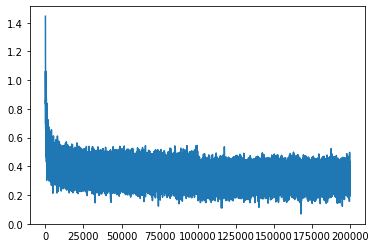

In [9]:
plt.plot(lossi)
plt.show()

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.1240577697753906
dev loss: 2.165454626083374


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]              # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)                # concatenate the vectors
        h = torch.tanh(x @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))              # decode and print the generated word

carpah.
amorie.
khirmy.
xhetty.
salayson.
mahnen.
den.
art.
kaqui.
nellaiah.
maiir.
kaleigh.
ham.
jorn.
quintis.
lilea.
jadii.
wazelo.
dearyn.
kai.


------
## 1.1.  Fixing the Initial Loss<a id="101"></a>
-----

We can tell that out network is very improperly configured at initialization. We can tell the initialization is bad because the first/zeroth iteration loss is extremely high. 
```
In neural network training, it's very likely that we have a rough idea of what loss to expect at initialization and that depends on the loss function and the problem set-up.
````
In our case, we don't expect an initialization training loss of $\boldsymbol{27}$, we expect a much lower number which we can calculate.

At initialization, there are 27 characters that could be predicted next for any single training example. At initialization, each character is equally likely therefore we would expect a uniform distribution - of predicted probabilities - assigning about equal probability to all the 27 characters (`1/27.0 ~= 3.7%`).

$$\\{logits}_{ij} = \frac{e^{C_{ij}}}{\sum_{j} e^{C_{ij}}} = \frac{C}{27C} = \frac{1}{27}$$

----

In [12]:
expected_loss = - torch.tensor(1 / 27).log()
print(expected_loss)

tensor(3.2958)


----
The expected loss is $\boldsymbol{3.29}$ which is much lower than $\boldsymbol{27}$. This is because at initialization the neural net is creating probability distributions that are all messed up. Some characters are very confident while some characters are very non-confident. So essentially, the network is _**very confidently wrong**_ which leads to a <u>very high loss.</u> Our loss is high because our network, rather arbitrarily, assigns very high probabilities to the incorrect label (or low probability to the correct label). Below, let's go through a smaller **4-D** example of the issue.

----

In [13]:
# 4-dimensional example of the issue
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
#logits = torch.rand(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -1 * torch.log(probs[2])
#loss = -probs[2].log()
logits, probs, loss

(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

----
The high value of the loss function during the first iteration of our network indicates that the network was not initialized correctly. Since we have no information to indicate that one character is more likely to be better than others, it is reasonable to assume that the initial probability distribution is uniform. To achieve this, it is necessary for the logits to be approximately zero when the network is initialized.
```
Reminder: the probabilities are obtained by passing logits through the softmax function
```
But we need to initialize not the logits, but the weights and biases. How should they be initialized to get zero logits? One approach is to set all biases to zero and scale down a (*normal*) distribution of weights by a small factor, such as 0.01. However, we usually don’t set the weights exactly to zero (_**we want some symmetry breaking**_), as this can slow down the optimization process.

For our case, let's scale  `W2 = W2 * 0.01` & `b2 = b2 * 0` to get the `logits` to be closer to zero and therefore **prevent our network from being very confidently wrong.**

----

In [14]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


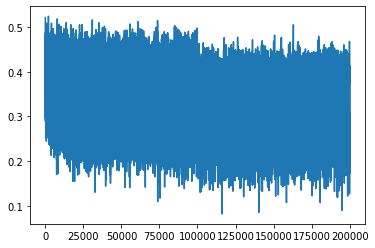

In [16]:
plt.plot(lossi)
plt.show()

----
The training loss plot doesn't have a _**hockey stick**_ shape anymore <u>because in the hockey stick, for the very first few iterations of the loss, the optimization is squashing down the logits and then rearranging them</u>. But now, we took away the easy part of the loss function where the weights were just being shrunk down and so therefore we don't get these easy gains in the beginning, instead we just get the hard gains of training the actual neural network, and therefore there's no hockey stick appearance.

----

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.069589138031006
dev loss: 2.131074905395508


----
With proper initialization of the training loop, the training and validation losses decrease from $\boldsymbol{2.124}$ and $\boldsymbol{2.165}$ to $\boldsymbol{2.069}$ and $\boldsymbol{2.131}$ respectively. This is because proper initialization allows us to spend more time/cycles optimizing the neural network instead of squashing down the weights in the first several thousand iterations. As a result, we don’t have the hockey stick behavior of the loss function at the beginning.

----

------
## 1.2.  Fixing the Saturated `tanh`<a id="102"></a>
-----
The next issue we encounter lies in the hidden state activations (`tanh` function). 

The range of the `tanh` function is between _\-1_ and _1_ and it is zero-centered ($\boldsymbol{-1 < tanh(x) < 1}$). When the pre-activation values (`hpreact`) become small or large, `tanh` saturates at -1 and 1. In the saturated region, the rate of change of `tanh` becomes zero, which hinders effective weight updates as shown in figures 1 & 2 below.

Thus if the pre-activation values lies in the saturating regions as shown in the figures below, then the `tanh` gradient will become $\boldsymbol{0}$ 
- `self.grad += (1-tanh²) * out.grad =  (1 - 1) * out.grad = 0`. 

It has no gradient to propagate. Weights will not be updated effectively. 

`NewWeight = OldWeight — learningrate * (derivative of error w.r.t weight)`

$\boldsymbol{f(x)}$ = 1 which is peak value. $\boldsymbol{f'(x)}$ will be 0.

<a id="b1"></a>
> A neuron is considered saturated when it reaches its peak value. At this point, the derivative of the parameter becomes zero, leading to no updates in the weights. This phenomenon is known as the **Vanishing Gradient problem.**

To address this, we should maintain pre-activations `hpreact = embcat @ (W1) + b1` close to zero, especially during initialization. This can be achieved by scaling down W1 and b1.
<a id="a1"></a>
![tanh(x)](_imgs/tanh_x.png)

**Fig. 1: Graph of `tanh(x)` from x=-4 to x=4.** ([Source](https://www.wolframalpha.com/input?i=graph+of+tanh%28x%29+for+-4%3Cx%3C4))<br><br>

<a id="a2"></a>
![derivative of tanh(x)](_imgs/derivative_tanh_x.png)
**Fig. 2: Graph of the derivative of `tanh(x)` from x=-4 to x=4.** ([Source](https://www.wolframalpha.com/input?i=graph+of+derivative+of+tanh%28x%29+for+-4%3Cx%3C4))<br><br>

----
The **activation function** maps the outputs from the linear layer to a range between -1 and 1. If we plot the distribution of activations, we will observe that most of the activations are either -1 or 1. This is because the distribution of preactivations (the values before being transformed by the activation function) is very broad.

Why is this a problem? During backpropagation, the gradient of the `tanh` function is proportional to `(1 — tanh²)`. When the value of `tanh` is close to 1 or -1, the gradient becomes almost zero, which stops the backpropagation through this unit.

Intuitively, it makes sense. In figure 1 above, if you are in the “flat” tail of the `tanh` curve, changes in the input do not have a significant impact on the output. Therefore, we can change the weights and biases as we want, and this will not affect the loss function. On the other hand, when the output of the `tanh` function is close to zero, the unit is relatively inactive and the gradient simply passes through without significant impact. In general, the more the output is in the flat regions of the `tanh` curve, the more the gradient is squashed.

----

In [18]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [19]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3221


In [20]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

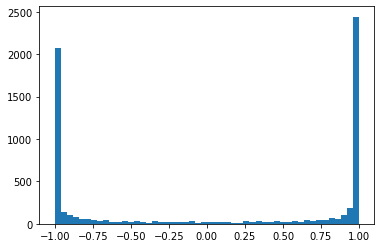

In [21]:
plt.hist(h.view(-1).tolist(), 50);

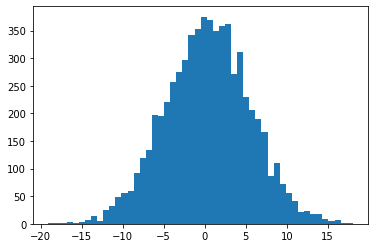

In [22]:
plt.hist(hpreact.view(-1).tolist(), 50);

----
When observing hidden layer activations, we can see that most of them are $1$ or $-1$. This is called the saturation of the `tanh` units. When the outputs of the `tanh` units are close to $1$ or $-1$, the gradients are close to $0$.

During backpropagation, these saturated units kill the gradient flow. Now let’s observe the distribution of the saturated units. The code below represents neurons with values less than $-0.99$ or greater than $0.99$ as white dots.

----

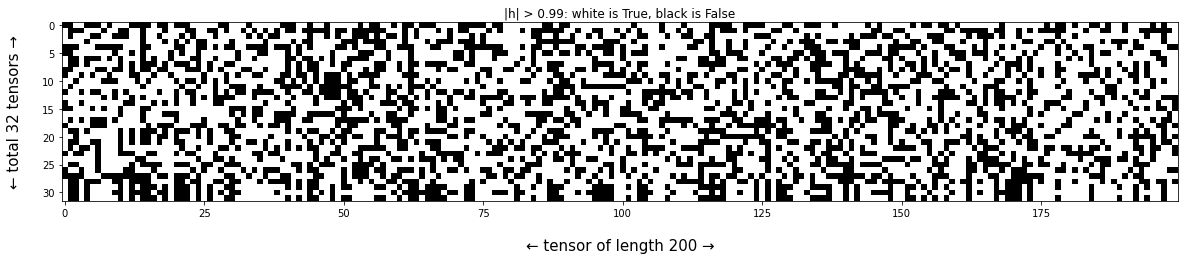

In [23]:
# Show the neurons as white dot with value less than -0.99 or greater than 0.99. 
#This is a boolean tensor. [statement = h.abs() > 0.99]
#White: statement is true
#Black: statement is false

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')
plt.title("|h| > 0.99: white is True, black is False")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});

----
**Dead neurons** refer to neurons that always output either $1$ or $-1$ for the `tanh` activation function, regardless of the input. Dead neurons are unable to learn and adapt to new data, as their gradients are always zero. This can occur at either the initialization or optimization stage for various types of non-linearities such as <u>`tanh`, `sigmoid`, `ReLU` & `ELU`</u> with flat tails where the gradients are zero. For example, if the learning rate is too high, a neuron may receive a strong gradient and be pushed out of the data manifold, resulting in a dead neuron that is no longer activated. This can be thought of as a kind of permanent brain damage in the network’s mind.

Some other activations, such as Leaky ReLU, don’t suffer as much from this problem because they don’t have flat tails.

**How to identify dead neurons?** Forward the examples from the entire training set through the network after training. Neurons that never activate are dead and therefore do not contribute to the learning process.

To **address the problem of dead neurons**, it is important to keep the preactivations close to zero. One way to do this is to **scale the preactivations to limit their range.** This can help prevent the gradients from becoming too small or zero, allowing the neuron to continue learning and adapting to new data.

<a id="b101"></a>For our case, let's scale `W1 = W1 * 0.2` & `b1 = b1 * 0.01`  to get the `hpreact` to be closer to zero and therefore **minimize the vanishing gradient problem.**
<br><br>

----

In [24]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3135


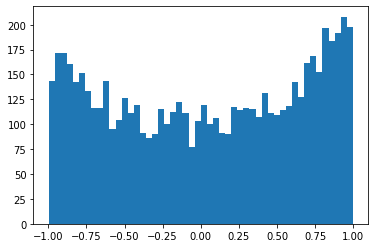

In [26]:
plt.hist(h.view(-1).tolist(), 50);

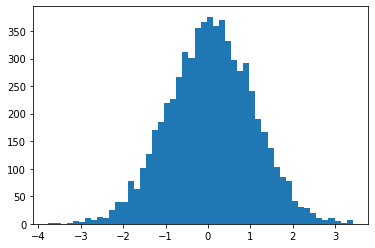

In [27]:
plt.hist(hpreact.view(-1).tolist(), 50);

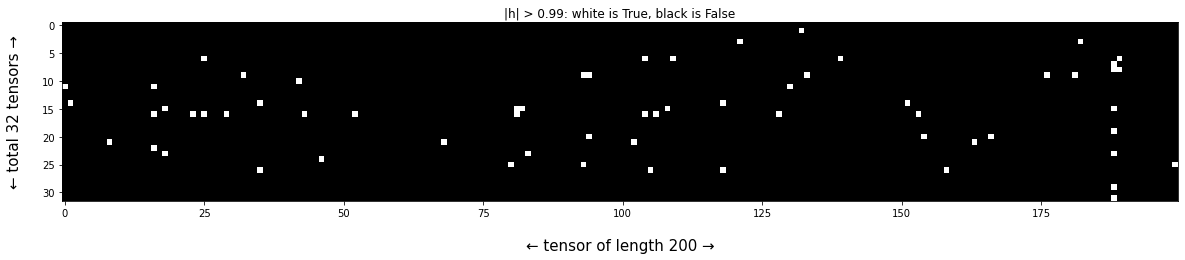

In [28]:
# Show the neurons as white dot with value less than -0.99 or greater than 0.99. 
#This is a boolean tensor. [statement = h.abs() > 0.99]
#White: statement is true
#Black: statement is false

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')
plt.title("|h| > 0.99: white is True, black is False")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});

----
Now Let's run the full training and optimization loop without the break.

----

In [29]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [30]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


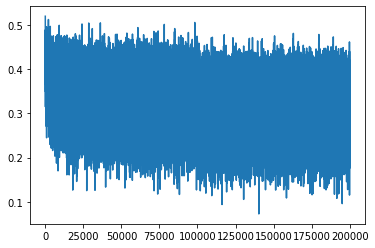

In [31]:
plt.plot(lossi)
plt.show()

The training loss plot doesn't have a _**hockey stick**_ shape anymore <u>because in the hockey stick, for the very first few iterations of the loss, the optimization is squashing down the logits and then rearranging them</u>. But now, we took away the easy part of the loss function where the weights were just being shrunk down and so therefore we don't get these easy gains in the beginning, instead we just get the hard gains of training the actual neural network, and therefore there's no hockey stick appearance.


In [32]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.0355966091156006
dev loss: 2.1026785373687744


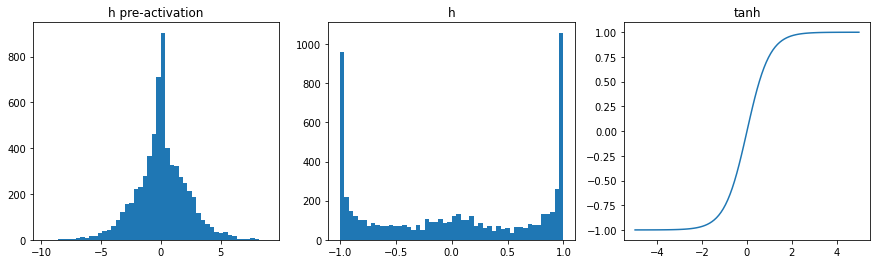

In [33]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))


axes[0].hist(hpreact.flatten().data, bins = 50)
axes[0].set_title("h pre-activation")

axes[1].hist(h.flatten().data, bins = 50)
axes[1].set_title("h")

axes[2].plot(torch.linspace(-5, 5, 100), torch.tanh(torch.linspace(-5, 5, 100)))
axes[2].set_title("tanh");

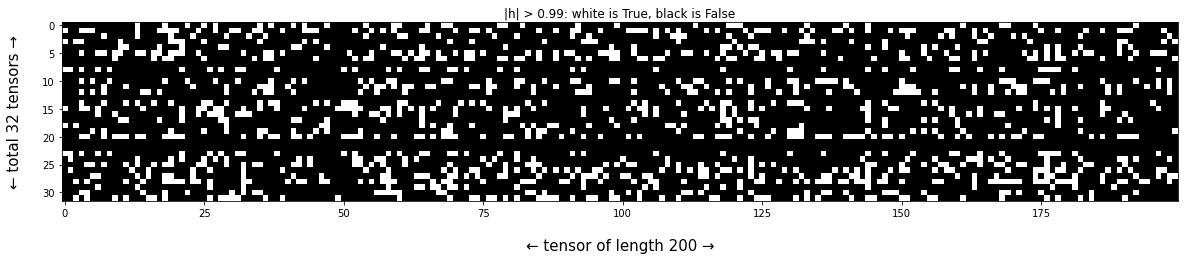

In [34]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation='nearest')
plt.title("|h| > 0.99: white is True, black is False")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});

----
With **fixing the saturated `tanh` function and dead neuron issues**, the training and validation losses decreased even further from $\boldsymbol{2.124}$ and $\boldsymbol{2.165}$ to $\boldsymbol{2.035}$ and $\boldsymbol{2.103}$ respectively. This is because the less the output is in the flat regions of the `tanh` curve, the less the gradient is squashed, and the more gradients are activated and non-zero thereby allowing the neuron to continue actual learning and adapting to new data. 

The losses keep reducing because our initialization is better and as such we spend more time doing productive training instead of non-productive training (softmax over-confidence learning and cycles of squahsing down the weight matrix). This shows the impact of initialization on performance solely from considering the MLP internals, activations and gradients.

We're working with a simple 1-layer MLP, which is quite shallow. Because of the shallow nature of the network, the optimization problem is quite easy & very forgiving and this is reflected in the network's ability to still learn eventually despite the terrible initialization (although the result is a bit worse). This is not the general case, especially once we start to work with deeper networks (ex. $50$ layers) because things get more complicated and these issues stack up. Basically, it can get to a point where the network does not train at all if the initialization is bad enough. Essentially, the deeper your network is, the more complex it is and the less forgiving it is to some of these errors. This is a scenario to be cautious and aware of, which you can diagnose/scrutinize by visualizations.


------
## 1.3.  Calculating the Init Scale: **"Kaiming Initialization"**<a id="103"></a>
-----

We need a defined semi-principled methodology that govern the scaling of the initialization sizes (weights and biases) rather than picking arbitrarily small numbers so things can be predefined and set for large neural networks with a lot of layers.

* How much should we limit the sizes of the initialization?<br>
* Where did the scale factors ($\boldsymbol{0.01}$, $\boldsymbol{0.1}$, $\boldsymbol{0.2}$) come from in initializing the weights and biases?



tensor(-0.0085) tensor(0.9879)
tensor(-0.0006) tensor(0.9880)


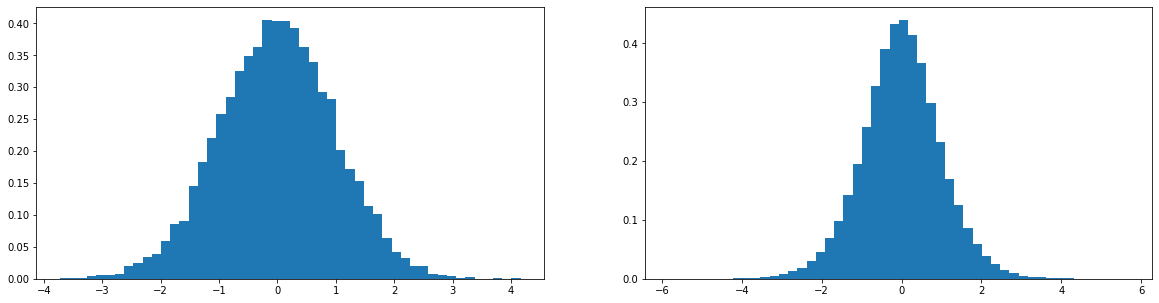

In [35]:
x = torch.randn(1000,10)
W = torch.randn(10,200) / 10**0.5
y = x @ W
print(x.mean(),x.std())
print(y.mean(),y.std())

plt.figure(figsize =(20,5))

plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density = True)

plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density = True);

----
* How do we scale the weights to preserve the gaussian distribution (`mean = 0` & `std_dev = 1`) from X in Y?
* More specifically, what scaling factor do we apply to the weights to preserve the standard deviation of 1 (`std_dev = 1`) ?

**Standard deviation and weights scaling**

When we pass the input _X_ through a linearity with weights _W_, the standard deviation of the output _Y = W\*X_ changes (increase or decrease) depending on the values of the weights. In order to maintain relatively similar activations throughout the neural network, it is important to scale the weights in a way that preserves the standard deviation of the output at a value of 1.  One method for doing this is to follow the [Kaiming He et. al. paper](https://arxiv.org/pdf/1502.01852.pdf), which recommends _**dividing the weights by the square root of `fan_in` (num. of inputs) or `fan_out` (num. of outputs) and multiplying by the gain function**_. The implementation of the **Kaiming normal distribution** can be found in [Pytorch](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

Why do we need gain on top of the initialization? All non-linearities are **contractive transformations**, which means they “squeeze” the data and reduce the standard deviation. To counter this effect, it is necessary to “boost” the weights slightly using a gain function. By scaling the weights in this manner, we can ensure that the standard deviation of the output is not affected by the scaling.

Modern innovations have made neural networks less fragile (~9 yrs ago, more finicky initializations, need for precision and care in handling activations & gradients, $-$ their ranges, their histograms $-$ gains, non-linearities), significantly more stable and more well-behaved, and thus exact network initializations have become less important. Some of these modern innovations are:
* **residual connections**
* the use of a number of normalization layers
    - **batch normalization**
    - group normalization
    - layer normalization
* much better optimizers
    - RMSprop
    - **Adam**
    
----

In [36]:
(torch.randn(10000) * 0.2).std()

tensor(0.2014)

In [37]:
(5/3) / (30**0.5)

0.3042903097250923

In [38]:
torch.nn.init.calculate_gain('tanh')

1.6666666666666667

----
The **Kaiming Initialization** scaling factor for the `tanh` function using the equation above is <br><br>
$$
\\Std = \frac{gain}{\sqrt{{fan}_{mode}}} = \frac{{gain}_{\tanh}}{\sqrt{{fan}_{in}}} = \frac{{gain}_{\tanh}}{\sqrt{{n}_{embd}\times{block}_{size}}} =
\frac{5/3}{\sqrt{10\times3}}
$$
 
 where
* `fan_mode` = `fan_in` = `n_embd * block_size` (default of ${fan}_{mode}$ is ${fan}_{in}$)
* `gain` = `torch.nn.init.calculate_gain('tanh')` = `5/3`
* `std` = `gain/sqrt(fan_mode)` = `(5/3) / (30**0.5)`

----

In [39]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [40]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


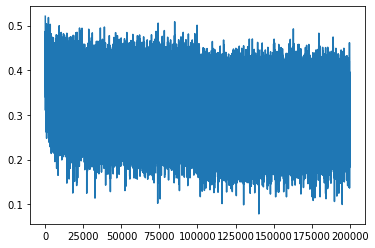

In [41]:
plt.plot(lossi)
plt.show()

In [42]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.0376644134521484
dev loss: 2.106989622116089


----
With **kaiming initialization**, the training and validation losses decreased even further from $\boldsymbol{2.124}$ and $\boldsymbol{2.165}$ to $\boldsymbol{2.037}$ and $\boldsymbol{2.107}$ respectively. However, both **kaiming init** losses are similar to the losses from **fixing the saturated `tanh` layer**. But the good thing now is that we didn't have to pick arbitrary numbers for the initialization scaling factors.


------
## 1.4.  Batch Normalization<a id="104"></a>
-----
[**Batch normalization**](https://arxiv.org/pdf/1502.03167) came out in 2015 by a Google team.

We don’t want the preactivations to be either too small or too large, because then our non-linearity either does nothing or gets saturated respectively. It destabilizes the network. To avoid this, _**we normalize the hidden state activations to be Gaussian in the batch.**_ This normalization is a differentiable operation and thus can be used in neural networks. <u>_We want the activations to be Gaussian at initialization but then allow backpropagation to tell us how to move them around during training._</u> We don’t want the distribution to be permanently constrained to a Gaussian shape. Ideally, we would allow the neural network to adjust this distribution, making it more diffuse or sharper, or allowing some `tanh` neurons to become more or less responsive. We want the distribution to be dynamic, with backpropagation guiding its adjustments.

Therefore, in addition to standardizing the activations at any point in the network, it’s also necessary to introduce a _**‘scale and shift'**_ component. This allows the model to undo the normalization if it determines that it’s better for the learning process. For this purpose, we introduce batch normalization gain and offset parameters, which are optimized during training, to scale and shift the normalized inputs respectively. Below is a figure showing the **Batch Normalizing Transform, applied to activation $x$ over a mini-batch**,  $B{N}_{\gamma,\beta}({x}_{i})$



<a id='a3'></a>
![Batch_norm](_imgs/batch_norm.png)
**Figure 3. Batch Normalization Algorithm.** ([Source](https://arxiv.org/pdf/1502.03167)) 
<br><br>

In [43]:
hpreact.shape

torch.Size([32, 200])

In [44]:
hpreact.mean(0, keepdim=True).shape, \
hpreact.std(0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [45]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

12297


In [46]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


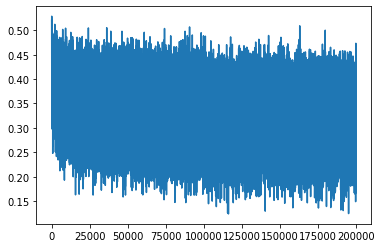

In [47]:
plt.plot(lossi)
plt.show()

----
**We can view the loss across batches of 1000 and take the mean for every batch. The loss is dropping which is good!**

----

In [48]:
torch.tensor(lossi).view(-1, 10000).mean(1)

tensor([0.3693, 0.3514, 0.3461, 0.3428, 0.3398, 0.3386, 0.3372, 0.3360, 0.3350,
        0.3345, 0.3225, 0.3219, 0.3209, 0.3208, 0.3210, 0.3195, 0.3198, 0.3199,
        0.3192, 0.3190])

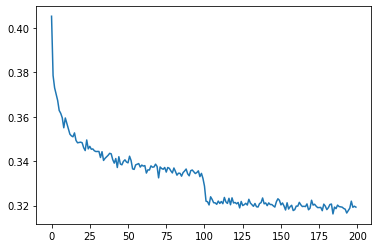

In [49]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [50]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.0668270587921143
dev loss: 2.104844808578491


----
With **batch normalization**, the training and validation losses decreased even further from $\boldsymbol{2.124}$ and $\boldsymbol{2.165}$ to $\boldsymbol{2.0668}$ and $\boldsymbol{2.1048}$ respectively. However, it doesn't necessarily improve on **kaiming initialization** and this is because of the simple nature of our neural network with only one hidden layer.

------

Tuning the scale of weight matrices of deeper neural networks with lots of different types of operations such that all the activations throughout the neural net are roughly gaussian will be extremely difficult, and become very quickly intractable. However, in comparison, it'll be much more easier to sprinkle batch normalization layers throughout the neural network. In neural networks, it's customary to append a batch normalization layer right after a linear/convolutional layer to control the scale of the activations throughout the neural network. It doesn't require the user to perform perfect mathematics or care about the activation distributions for all the building blocks the user might want to introduce into the neural network. It also significantly stabilizes the training.

Stability comes with a cost. _**In batch normalization, we mathematically couple the examples within a batch.**_ The hidden states and logits for any example are no longer a function of that one example, but a function of all other examples that happen to be in the same batch. And that sample batches are randomly selected!

This coupling effect (2nd-order effect), despite its shortcomings, has a positive side. Padding out all the examples in the batch introduces a bit of entropy and this _**acts as a regularization**_. It's basically a form of **data augmentation**. As a result, it is harder to overfit these concrete examples. Other normalization techniques that don't couple the examples of a batch are layer, group and instance normalization.

Batch normalization requires that all examples be packaged in batches. But what do we do in inference mode when we usually feed only one example into the neural network? The solution is to _**compute the batch mean and standard deviation over the entire training set**_ and use these parameters at inference time.

---
After deployment, the model should generate a single output for a single input. We should be able to forward a single example. At the end of the training, we will calculate the mean and standard deviation of the hidden activations $w.r.t$ the entire training data set and use it in the forward pass. The means and standard deviations will be used during inference.
As per the `BatchNorm` paper, we would like to have a step after training that calculates and sets the `BatchNorm` mean and standard deviation a single time over the entire training set. Let's calibrate the `BatchNorm` statistics:

----

In [51]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [52]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.066890239715576
dev loss: 2.1049015522003174


----
However, nobody wants to evaluate the training mean and standard deviation of an entire dataset as a separate step. We want to calculate the mean and standard deviation of the entire training set, during the training time. _**Instead, we want to do it in a running manner directly during the training process as proposed in the `BatchNorm` paper.**_ We can use running means and averages in the forward pass. The rolling sum method allows one to do this. Note that a small momentum factor in the rolling sum may not result in an accurate estimates due to large differences between batches.

<a id="b2"></a>It is very important to **adjust the momentum factor** $w.r.t$ batch size to ensure convergence of the running mean and standard deviation estimates to the actual mean and standard deviation over the entire training set. For example, a small batch size of 32 will have a higher variance in the mean and standard deviation across different batches; a momentum factor of 0.1 might not be sufficient for accurate estimation or proper convergence of the running parameters, and so we use a momentum factor of 0.001 instead.

----

In [53]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

12297


In [54]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


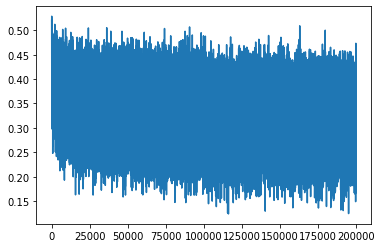

In [55]:
plt.plot(lossi)
plt.show()

----
**We can view the loss across batches of 1000 and take the mean for every batch. The loss is dropping which is good!**

----

In [56]:
torch.tensor(lossi).view(-1, 10000).mean(1)

tensor([0.3693, 0.3514, 0.3461, 0.3428, 0.3398, 0.3386, 0.3372, 0.3360, 0.3350,
        0.3345, 0.3225, 0.3219, 0.3209, 0.3208, 0.3210, 0.3195, 0.3198, 0.3199,
        0.3192, 0.3190])

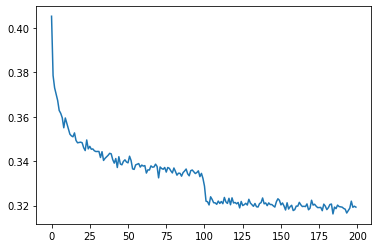

In [57]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [58]:
# fairly similar mean and std values for batchnorm and batchnorm_running 
(bnmean - bnmean_running).mean(), (bnstd - bnstd_running).mean()

(tensor(0.0012), tensor(0.0231))

In [59]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.06659197807312
dev loss: 2.1050572395324707


----
Let's dive into `epsilon` in the normalization step of the batch normalization algorithm in the equation below:
$$
\hat{x}_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}}
$$


What is $\epsilon$ in the normalization step used for? 

It is usually a very small fixed number (example: `1E-5` by default). It basically prevents a division by zero, in the case that the variance over a batch is exactly zero.

---

_**Note that biases become useless when batch normalization is applied.**_ They are canceled when subtracting the mean at the batch normalization level and thus do not affect the rest of the calculation. Instead, we have a batch normalization bias that is responsible for biasing the distribution. Batch normalization layers are placed after the layers where multiplications happen.

_**A typical simple neural network unit block consists of a linear (or convolutional) layer, a normalization (batch) layer, and a non-linearity layer.**_ Adding batch normalization allows you to control the scale of activations in your neural network and care less about its distributions in all the building blocks of your network architecture.<br><br>
\begin{equation}
\textbf{Generic NN Unit Block:} \\
\text{Weight Layer (Linear/Convolutional)} \rightarrow \text{Normalization Layer (BatchNorm)}\rightarrow\text{Nonlinearity Function (tanh/ReLU)}
\end{equation}

------
## 1.5.  Batch Normalization: Summary<a id="105"></a>
-----
Batch normalization is used to control the statistics of the neural network activations. It is common to sprinkle batch normalization across the neural networks. Usually, batch normalization layers are placed after layers that have multiplications such as linear/convolutional layers. Batch normalization internally has parameters for the gain and bias which are trained using backpropagation. It also has 2 buffers: the mean and the standard devation. The buffers are trained using a running mean update.

Steps of batch normalization explicitly: 
* calculate mean of activations feeding into the batch-norm layer over that batch
* calculate standard deviation of activations feeding into the batch-norm layer over that batch 
* center the batch to be unit gaussian
* scale and offset that centered batch by the learned gain and bias respectively
* Throughout the previous steps, keep track of the mean and standard deviation of the inputs so as to maintain the running mean and standard deviation which will later be used at inference to prevent re-estimation of mean and standard deviation all the time. This allows us to forward individual examples during testing phase

Batch Normalization can become [computationally expensive, is a common source of bugs because it couples examples together and calculates distributions with respect to the other examples, and cannot be used for certain tasks as it breaks the independence between examples in the minibatch;](https://twitter.com/sohamde_/status/1360219421713838080?lang=en) but it’s useful because:

*   It **reduces the internal covariate shift** and improves the gradient flow 
    - Batch normalization helps to <a id="b102"></a><u>mitigate the vanishing and exploding gradient problems by ensuring that the activations have approximately zero mean and unit variance.</u> This normalization of inputs ensures that gradients flow more smoothly during backpropagation, making the optimization process more stable and enabling faster convergence.
*   Batch normalization acts as a **form of regularization** by adding noise to the input of each layer. This noise, introduced by the normalization process, helps **prevent overfitting** by adding a small amount of randomness to the activations during training.
*   Batch normalization **makes neural networks less sensitive to the choice of initialization parameters and can increase the rate of learning to reach convergence faster.**

----

In [60]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

12097


In [61]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
#epsilon = 1E-5

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 #+ b1                       # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


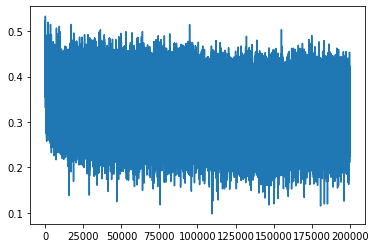

In [62]:
plt.plot(lossi)
plt.show()

In [63]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1                        # (N, n_hidden)
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.0674147605895996
dev loss: 2.1056838035583496


------
## 1.6. Real Example: `ResNet50` Walkthrough<a id="106"></a>
-----
**ResNet** is a residual neural network for image classification, consisting of repeating _**"bottleneck blocks"**_ that process input data through **convolutional layers, batch normalization, and nonlinearity**, ultimately leading to predictions about the image's contents. It was launched by Microsoft in 2015 with a design structure that was chosen specifically to address the </a>vanishing/exploding gradient problem. 
 <br><br>
<a id='a4'></a>
![Resnet](_imgs/resnet.png)<br>
**Figure 4. ResNet-34 Architecture.** ([Source](https://arxiv.org/pdf/1512.03385v1))<br><br>

----
The image is fed into the network, which consists of many layers with a repeating structure, ultimately leading to predictions about the image's contents. This repeating structure is made up of _**"bottleneck blocks"**_ that are stacked sequentially. The code for these blocks initializes the neural network and defines how it processes input data through the forward pass. <u>Convolutional layers</u> are used for images, applying linear multiplication and bias offset to overlapping patches of the input. <u>Batch normalization</u> and <u>nonlinearity,</u> such as `ReLU`, are also applied in the network. For extremely deep neural networks, `ReLU` typically empirically works slightly better than `tanh`.

ResNet full `PyTorch` code implementation can be found in [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py). In the **bottleneck block** class module of the full code, the `init` function initializes the neural network and all its layers, and the `forward` function specifies the neural network's processing actions once all the inputs are ready. These actions include applying  convolutional layers, batch normalization, nonlinearity function, and **residual connections** which we haven't covered yet. These blocks are basically replicated and stacked up serially. to form a **Residual Network.**

----

<br><br>
\begin{equation}
\textbf{Generic NN Unit Block:} \\
\text{Weight Layer (Linear/Convolutional)} \rightarrow \text{Normalization Layer (BatchNorm)}\rightarrow\text{Nonlinearity Function (tanh/ReLU)}
\end{equation}
<br>
\begin{equation}
\textbf{Residual Network Unit Block:} \\
\text{Convolutional Layer} \rightarrow \text{Batch Normalization Layer} \rightarrow \text{ReLU}
\end{equation}

<a id='a5'></a>
![Resnet Bottleneck Builiding Block](_imgs/resnet_bottleneck_block.png)
<br>**Figure 5. ResNet Bottleneck Unit Building Block.** ([Source](https://arxiv.org/pdf/1512.03385v1))<br><br>

----
ResNets utilize a technique called [**skip connections**](https://medium.com/@siddheshb008/resnet-architecture-explained-47309ea9283d). Skip connections bypass intermediate layers, linking layer activations to subsequent layers. This forms a residual block. Stacking these residual blocks creates ResNets. The advantage of incorporating skip connections is that they <u>allow regularization to bypass any layer that degrades the architecture's performance.</u> As a result, training extremely deep neural networks becomes possible without encountering issues with <a id="b103"></a>vanishing or exploding gradients. Overall, ResNet uses a combination of convolutional layers, batch normalization, and nonlinearity to process images and make predictions about their contents.

----

------
## 1.7.  Summary of the Lecture so far<a id="107"></a>

-----
So far, the lecture covered the **challenge of scaling weight matrices and biases during neural network initialization** to ensure that activations are roughly uniform throughout the network. This led to the **development of the normalization layer, particularly the batch normalization layer,** which allows for _**roughly Gaussian activations**_ by centering the data using the mean and standard deviation. However, the layer has its complexities, such as needing to estimate the mean and standard deviation during training, and coupling examples in the forward pass of a neural net which causes several bugs. Hence, some recommended alternatives are group normalization or layer normalization. 

This lecture covered the importance of understanding activations and gradients, and their statistics in neural networks, especially as they become larger and deeper. We saw how distributions at the output layer can lead to "hockey stick losses" if activations are not controlled, and how fixing this issue can improve training. We also discussed the need to <u>control activations to avoid squashing to zero or exploding to infinity, and how this can be achieved by scaling weight matrices and biases during initialization.</u>

The lecture then introduced the concept of normalization layers, specifically batch normalization, which helps achieve roughly Gaussian activations. Batch normalization works by centering and scaling data which are differentiable operations, but requires additional complexity to handle gain, bias, and inference. While influential, batch normalization can be problematic and has been largely replaced by alternatives like group normalization and layer normalization. The lecture concluded by highlighting the importance of controlling activation statistics, especially in deep neural networks.

In summary, the lecture emphasized the **importance of understanding and controlling activations and gradients in neural networks,** especially in deep networks. It introduced the concept of normalization layers, specifically batch normalization, which helps achieve roughly Gaussian activations. While batch normalization has been influential, it has limitations and has been largely replaced by alternatives. The lecture highlighted the importance of **controlling activation statistics for good performance,** especially in deep neural networks.

Next, we can move on to **recurrent neural networks (RNNs)**. As we'll see, RNNs are essentially very deep networks, where you unroll the loop and optimize the neurons. This is where the analysis of activation statistics and normalization layers becomes crucial for good performance. We'll explore this in more detail in another notebook.

----
## Summary of loss logs with forward pass activations improvements
-----
* **original:**
    - train loss: 2.1240577697753906
    - dev loss:   2.165454626083374
<br>
* **fix softmax confidently wrong:**
    - train loss: 2.0696
    - dev loss:   2.1310
<br>
* **fix `tanh` layer too saturated at init:**
    - train loss: 2.0355966091156006
    - dev loss:   2.1026785373687744
<br>
* **use semi-principled "kaiming init" instead of hacky init:**
    - train loss: 2.0376644134521484
    - dev loss:   2.106989622116089
<br>
* **add batch norm layer:**
    - train loss: 2.06659197807312
    - dev loss: 2.1050572395324707
<br>

----

-----
## 1.8.  `PyTorch`-ifying the Code<a id="108"></a>

-----
Let's build the complete code in `PyTorch`. Below is a list of the **Kaiming initialization** parameters:

* `fan_in` is the number of input neurons 
* `fan_out` is the number of output neurons


Here are the **BatchNorm** layer initialization parameters:

*   `dim`: The dimensionality of the input tensor to be normalized.
*   `eps`: A small value added to the denominator to avoid division by zero. Default value is set to $1\times10^{-5}$
*   `momentum`: The momentum value used to update the running mean and variance during training. Default value is set to $0.1$

And these are the rest of the **BatchNorm** instance attributes:

*   `training`: A boolean flag indicating whether the batch normalization layer is in training mode.
*   `gamma`: Parameter tensor representing the scale factors, initialized to ones.
*   `beta`: Parameter tensor representing the shift factors, initialized to zeros.
*   `running_mean`: Buffer tensor for storing the running mean of activations.
*   `running_var`: Buffer tensor for storing the running variance of activations.


In [64]:
# SUMMARY + PYTORCHIFYING -----------

In [162]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), 
#   Linear(           n_hidden, n_hidden), 
#   Linear(           n_hidden, n_hidden), 
#   Linear(           n_hidden, n_hidden), 
#   Linear(           n_hidden, n_hidden), 
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    

46497


In [121]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.7561


---------
<br><br><a id="2"></a>
# 2. Visualizations
-------------------------------------------------------
### IMPORTANT: For each plot below, ensure the appropriate `gain` is properly defined in the prior cells. For the fully linear case (no `Tanh`, be sure to update `layers`) !!!
* <u>_**gain**_ changes for diagnostic study of forward pass activations and backward gradient activations</u>

```
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #change accordingly for diagnostic study
            
```

* <u>Fully linear case with no non-linearities (_**no `Tanh`**_)</u>

```
layers = [
  Linear(n_embd * block_size, n_hidden), #Tanh(), 
  Linear(           n_hidden, n_hidden), #Tanh(),
  Linear(           n_hidden, n_hidden), #Tanh(),
  Linear(           n_hidden, n_hidden), #Tanh(),
  Linear(           n_hidden, n_hidden), #Tanh(),
  Linear(           n_hidden, vocab_size),
]

```

### Re-initialize layers and parameters in [section 1.8](#108) (re-run both cells there) using the above changes before running the cells below 

----

## 2.1. Forward Pass Activation Statistics<a id="201"></a>
-----
Let's visualize the histograms of the forward pass activations at the `tanh` layers. We're using a `tanh` layer because it has a finite output range $\boldsymbol{[-1, 1]}$ which is very easy to work with. Also the gain for `tanh` is $\boldsymbol{5/3}$. 
- `layer.weight *= 5/3`

----

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


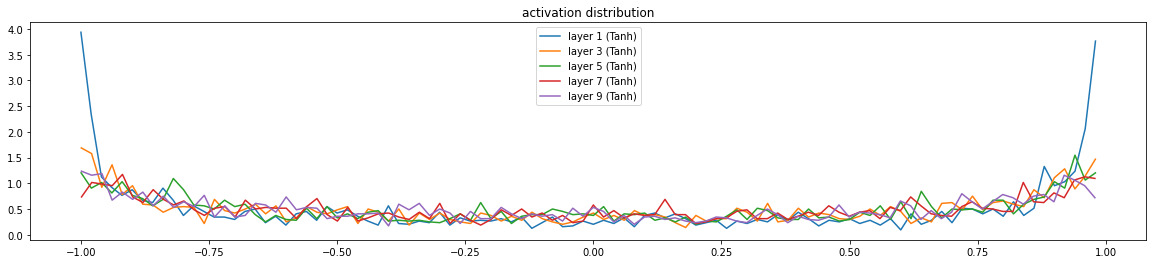

In [67]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

----
The first layer is fairly saturated ($\boldsymbol{\sim20\%}$). However, later layers become stable due to our initialization. This is because we multiplied the weights by a gain of $\boldsymbol{5/3}$. However, if we use a gain of $1$, we can observe the following scenario.
- `layer.weight *= 1`

----

layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


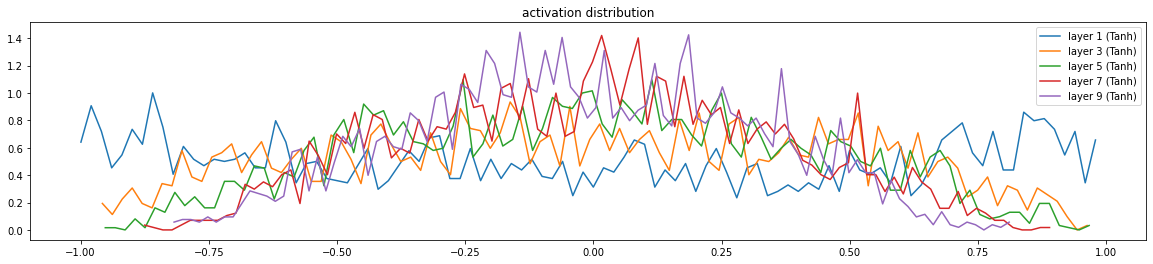

In [70]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

----
The saturation drops to $\boldsymbol{0\%}$. However, the standard deviation is also shrinking, thus, converging the whole distribution to zero. The `tanh` function squeezes the distribution. Thus, we need sufficient gain to fight the shrinking/squashing.

Let's try a gain of $\boldsymbol{3}$.
- `layer.weight *= 3`

----

layer 1 (      Tanh): mean -0.03, std 0.85, saturated: 47.66%
layer 3 (      Tanh): mean +0.00, std 0.84, saturated: 40.47%
layer 5 (      Tanh): mean -0.01, std 0.84, saturated: 42.38%
layer 7 (      Tanh): mean -0.01, std 0.84, saturated: 42.00%
layer 9 (      Tanh): mean -0.03, std 0.84, saturated: 42.41%


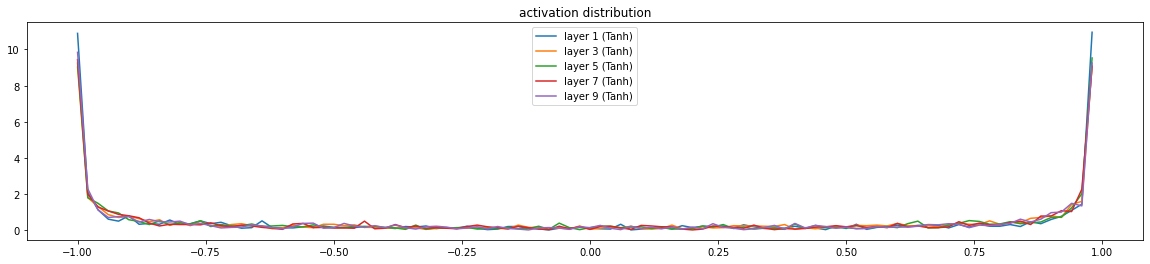

In [73]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

----
Now, the saturation is too high and does not converge to zero. Ultimately, a gain of $\boldsymbol{5/3}$ is the <u>**most suitable as it stabilizes the sandwich of `Linear` and `Tanh` layers and limits the saturation to a good low range ($\sim5\%$).**</u>

----

-----
## 2.2. Backward Pass Gradient Statistics<a id="202"></a>
-----
Let's visualize the histograms of the backward pass gradient at the `tanh` layers. First, let's use a gain of $\boldsymbol{5/3}$.

----

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


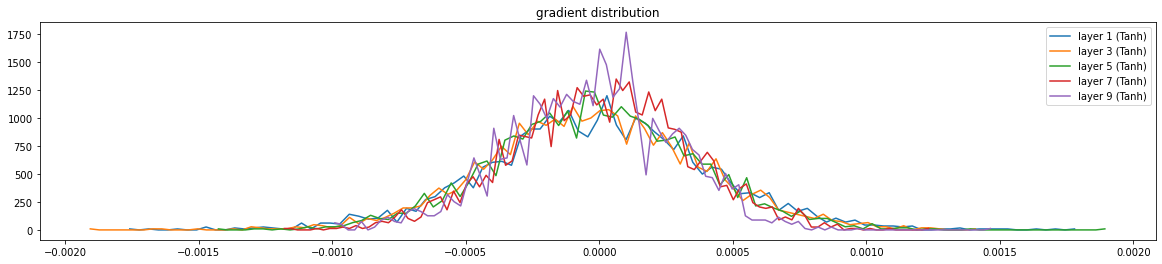

In [76]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution');

----
The gradient distribution is fairly reasonable. All the different layers have roughly the same distribution. Things are not shrinking or exploding. 

Now, let's use a gain of $\boldsymbol{0.5}$.
- `layer.weight *= 0.5`

----

layer 1 (      Tanh): mean +0.000000, std 1.892402e-05
layer 3 (      Tanh): mean -0.000001, std 3.943546e-05
layer 5 (      Tanh): mean +0.000004, std 8.035369e-05
layer 7 (      Tanh): mean +0.000009, std 1.561152e-04
layer 9 (      Tanh): mean -0.000014, std 3.053498e-04


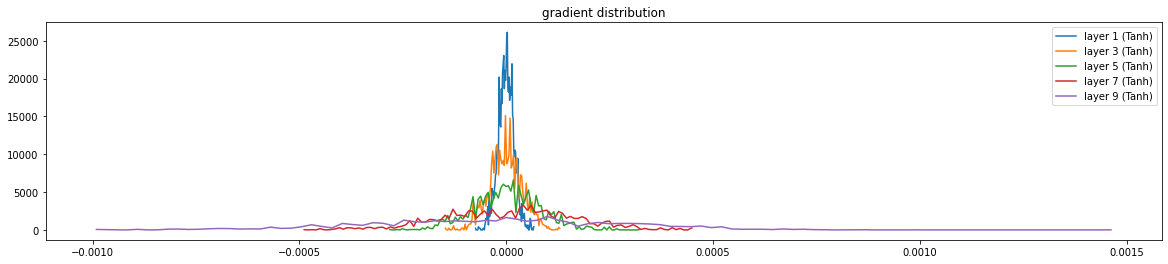

In [79]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution');

----
We can see that the activations are shrinking to $\boldsymbol{0}$ and the gradients are exhibiting **weird behavior** (<u>expanding out from bell curve shape to flat line</u>).

Now, let's use a gain of $\boldsymbol{3}$.

----

layer 1 (      Tanh): mean -0.000001, std 9.977493e-04
layer 3 (      Tanh): mean +0.000010, std 7.421208e-04
layer 5 (      Tanh): mean +0.000003, std 5.569782e-04
layer 7 (      Tanh): mean +0.000017, std 3.952166e-04
layer 9 (      Tanh): mean -0.000014, std 3.051525e-04


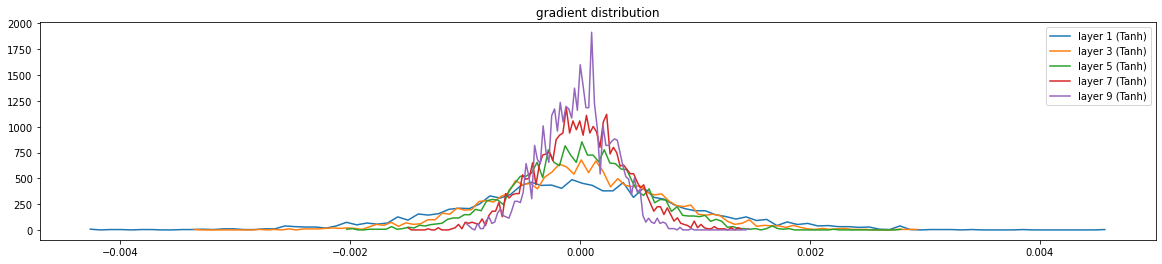

In [82]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution');

----
The gradients are <u>exhibiting an asymmetric behavior, as we progress into deeper and deeper layers the activations are also changing, which is not what we want.</u> Basically, **without the use of `BatchNorm`,** we have to **carefully set the gain to get nice activations** in both the forward pass and the backward pass.

----

## 2.3.  Fully Linear Case of No Non-Linearities<a id="203"></a>
-----
Let's visualize the forward pass activations and backward pass gradients for a fully linear case with no non-linearities. We remove all the `Tanh` from `layers`. Let's start with a gain of $5/3$.

---

layer 0 (    Linear): mean -0.04, std 1.65, saturated: 55.12%
layer 1 (    Linear): mean -0.04, std 2.72, saturated: 71.78%
layer 2 (    Linear): mean -0.00, std 4.67, saturated: 81.31%
layer 3 (    Linear): mean +0.09, std 7.50, saturated: 91.19%
layer 4 (    Linear): mean -0.72, std 12.78, saturated: 93.69%


Text(0.5, 1.0, 'activation distribution')

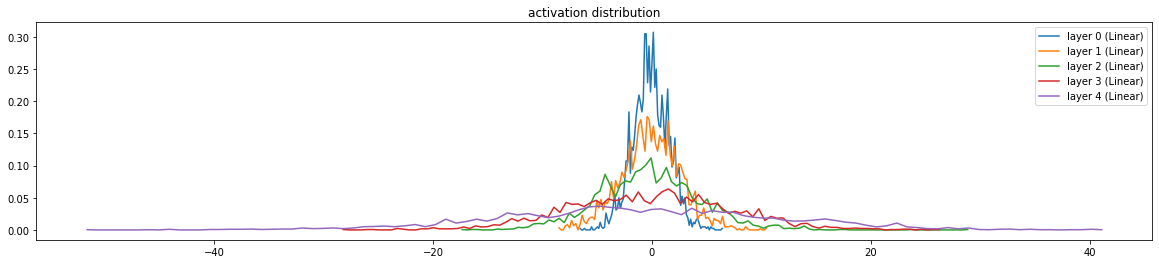

In [92]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000053, std 2.619184e-03
layer 1 (    Linear): mean -0.000006, std 1.583188e-03
layer 2 (    Linear): mean +0.000043, std 9.519162e-04
layer 3 (    Linear): mean +0.000019, std 5.457934e-04
layer 4 (    Linear): mean -0.000013, std 3.161244e-04


Text(0.5, 1.0, 'gradient distribution')

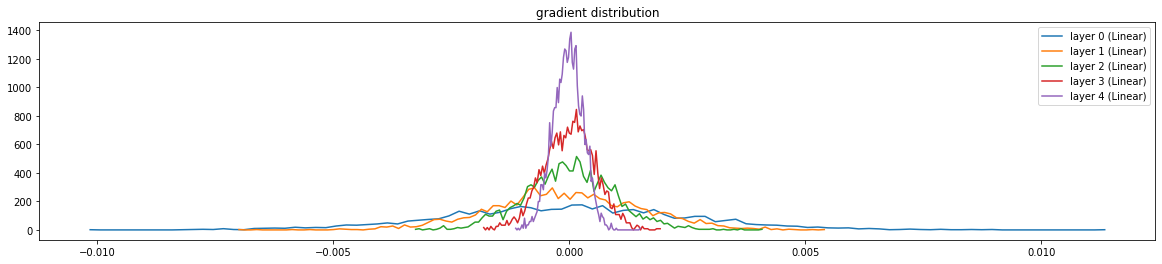

In [93]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

----
The **forward pass activations diffuse out and downwards** from layer $0$ (clear peak) to $4$ (flat line). The **backward pass gradients shrink inwards and upwards** as you go deeper in the layers. Basically, an _**asymmetry**_ exists in the neural network, and causes a vanishing/exploding gradient issue for deep neural networks (i.e. $\boldsymbol{>50}\textbf{ layers}$).

Let's change the gain to $\boldsymbol{0.5}$ and see what happens.

----

layer 0 (    Linear): mean -0.01, std 0.49, saturated: 5.06%
layer 1 (    Linear): mean -0.00, std 0.25, saturated: 0.00%
layer 2 (    Linear): mean -0.00, std 0.13, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.06, saturated: 0.00%
layer 4 (    Linear): mean -0.00, std 0.03, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

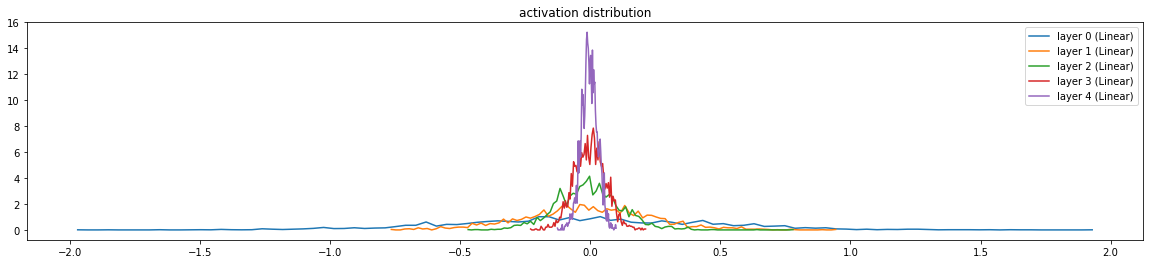

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000000, std 1.990759e-05
layer 1 (    Linear): mean -0.000001, std 3.997084e-05
layer 2 (    Linear): mean +0.000004, std 8.058026e-05
layer 3 (    Linear): mean +0.000009, std 1.562154e-04
layer 4 (    Linear): mean -0.000014, std 3.053490e-04


Text(0.5, 1.0, 'gradient distribution')

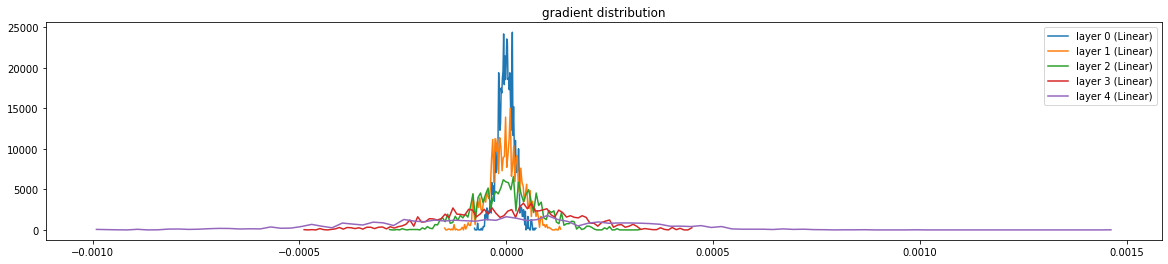

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

----
For **a very small gain,** the opposite effect of a large gain happens. The <u>forward pass activations shrink inwards and upwards from layer 0 (flat line) to 4 (clear peak). The backward pass gradients diffuse outwards and downwards (clear peak $\rightarrow$ flat line) as you go deeper in the layers ($0$ to $4$).</u> Basically, an _**asymmetry**_ still exists in the neural network.

Let's use a gain of $\boldsymbol{1}$.

----

layer 0 (    Linear): mean -0.02, std 0.99, saturated: 32.16%
layer 1 (    Linear): mean -0.01, std 0.98, saturated: 31.12%
layer 2 (    Linear): mean -0.00, std 1.01, saturated: 31.16%
layer 3 (    Linear): mean +0.01, std 0.97, saturated: 31.66%
layer 4 (    Linear): mean -0.06, std 0.99, saturated: 32.47%


Text(0.5, 1.0, 'activation distribution')

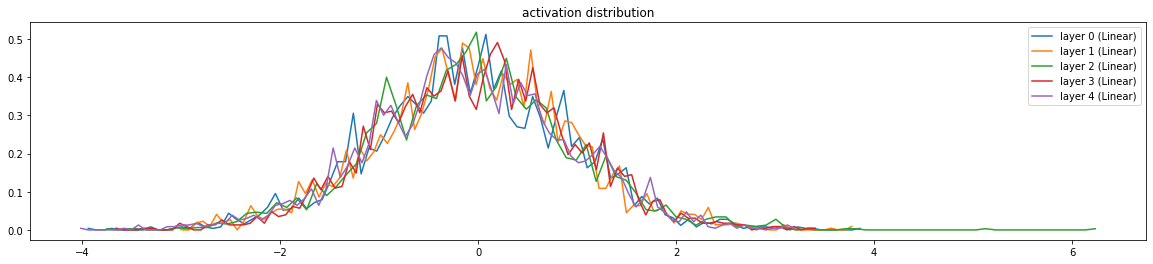

In [100]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000005, std 3.190493e-04
layer 1 (    Linear): mean -0.000004, std 3.204010e-04
layer 2 (    Linear): mean +0.000015, std 3.229072e-04
layer 3 (    Linear): mean +0.000018, std 3.127774e-04
layer 4 (    Linear): mean -0.000014, std 3.055150e-04


Text(0.5, 1.0, 'gradient distribution')

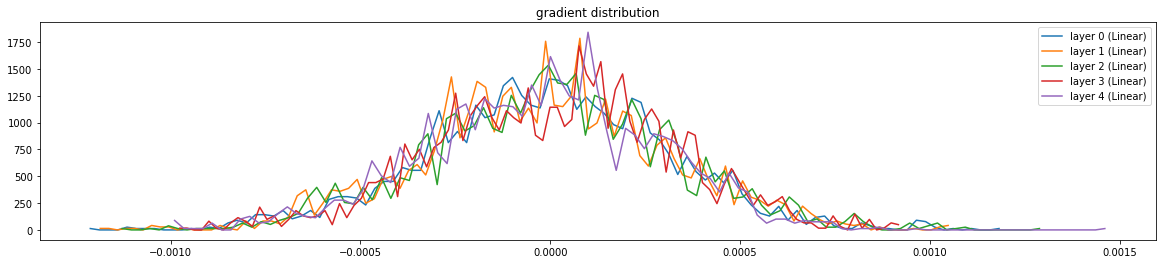

In [101]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

----
We can see that now the forward and backward pass statistics are well-behaved. Hence, we see that a gain of $\boldsymbol1$ is the best setting for the fully linear case with no non-linearities.

The **reason for studying this no nonlinearity case** is to show that getting a neural network to train before the use of normalization layers, advanced optimizers (Adam, etc.) and residual connections is basically a **balancing act (*visualize balancing a pencil on a finger*).** There has to be precise orchestration and balance in controlling the activations and gradients, and their statistics; and then maybe just maybe you can train the neural network. It was basically impossible to train very deep neural networks; you'd have to be extremely careful with your initialization.

To go even further, **why do we need the `Tanh` in the `layers`? Why do we have to worry about the `gain`?**

The reason is that if you just have a stack of linear layers, you're getting a massive linear sandwich that collapses to a single linear layer in terms of its representation power. If you were to plot the output as a function of the input, you're just getting a linear function, no matter how many linear layers you stack up. You still just end up with a linear transformation, and all the individual $Wx + b$ of  multiple linear layers just collapse into a large $Wx + b$ with slightly different $W$ and $b$.

However, even though the forward pass collapses to just a linear layer, the optimization is not identical due to backpropagation and the dynamics of the backward pass. You actually end up with all kinds of interesting dynamics in the backward pass because of the way the chain rule is calculating it. So, optimizing a linear layer by itself and optimizing a sandwich of tanh and linear layers - in both cases, those are just linear transformations in the forward pass - but the training dynamics would be different. There are entire papers that analyze infinitely layered linear layers, and there's a lot you can play with there. But basically, the technical nonlinearities allow us to turn this sandwich from just a linear function into a neural network that can, in principle, approximate any arbitrary function.

In summary, this explains why we need nonlinear layers (`tanh`) in neural networks, even though stacking linear layers would seem to suffice. **The issue is that a stack of linear layers collapses to a single linear layer, limiting its representation power. Nonlinear layers, on the other hand, allow the network to approximate any arbitrary function, and their optimization dynamics are different from those of linear layers, even though the forward pass may seem identical.**

----

## 2.4.  Parameter Activation & Gradient Statistics<a id="204"></a>
-----
Let's visualize the forward pass activations, backward pass gradients, parameters (weights) gradients for the original neural network with non-linearities and a gain of $\boldsymbol{5/3}$. The other parameters: bias, gamma, beta and batchnorms, are ignored (<u>restricting to ${2D}$ parameters:</u> set `p.ndim == 2`) in this diagnosis just for simplicity. The study of the weights gradients is instructive and applicable to the other parameters.

----

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

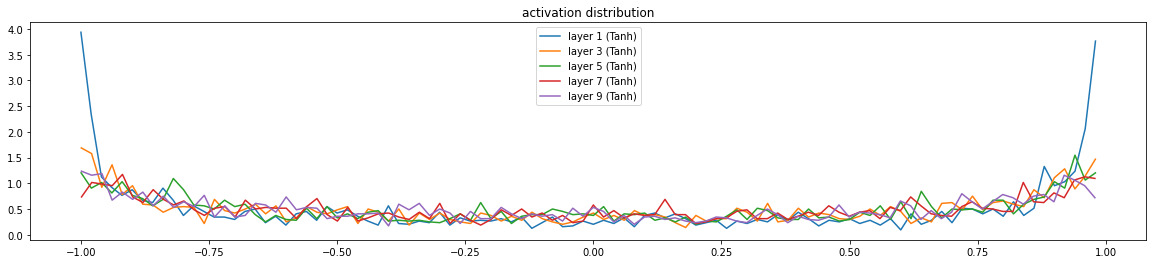

In [104]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

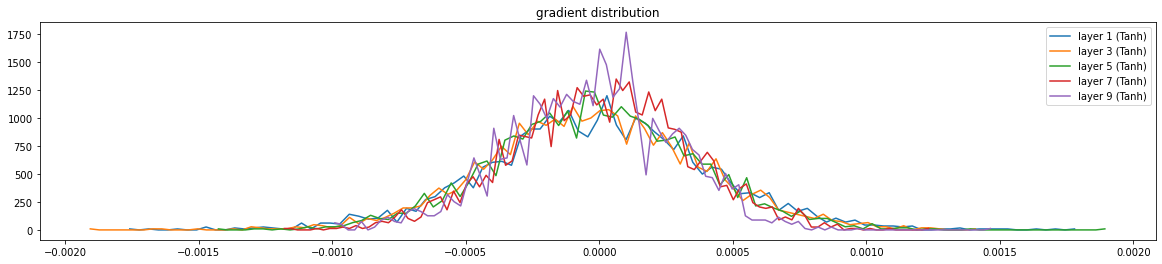

In [105]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


Text(0.5, 1.0, 'weights gradient distribution')

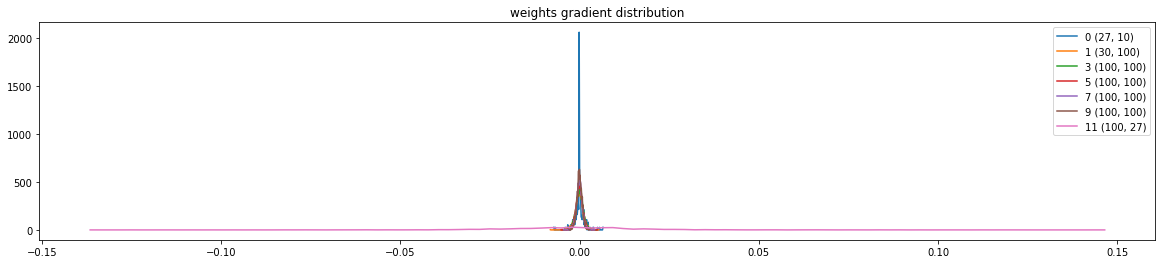

In [106]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

----
The weights gradient histogram plot above does not look that amazing, there are some issues and something weird is going on. However, the gradent-to-data ratio is reasonable and should be very small ($\sim10^{-3}$) since a scenario of extremely large gradient magnitude relative to the corresponding data numbers is very alarming. 

The last weight has a **high relative gradient-to-ratio value,** which is bad, as signified by the **pink line.** The plot shows that that particular weight parameter takes on much larger values than those inside the neural net and this is also seen in its relatively higher standard deviation value ($10$ times greater than those of the other weights). This is problematic because during Stochastic Gradient Descent (SGD), there will be a $\boldsymbol{10}\textbf{X}$ faster training speed at initialization for the last weight compared to the other weights. However, if you train for a little bit longer (`if i > 1000: break`), it kinda fixes itself a little bit:

```
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    if i > 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization
```

----

In [128]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [129]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    if i > 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


Text(0.5, 1.0, 'activation distribution')

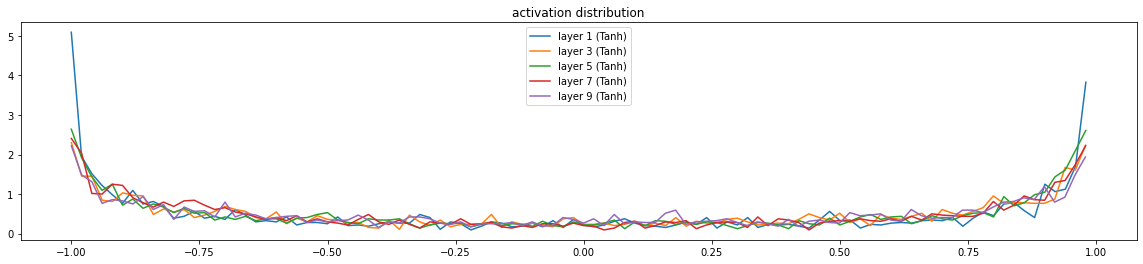

In [130]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000005, std 3.059083e-03
layer 3 (      Tanh): mean +0.000037, std 3.085332e-03
layer 5 (      Tanh): mean -0.000007, std 2.888205e-03
layer 7 (      Tanh): mean +0.000012, std 2.756316e-03
layer 9 (      Tanh): mean +0.000007, std 2.337389e-03


Text(0.5, 1.0, 'gradient distribution')

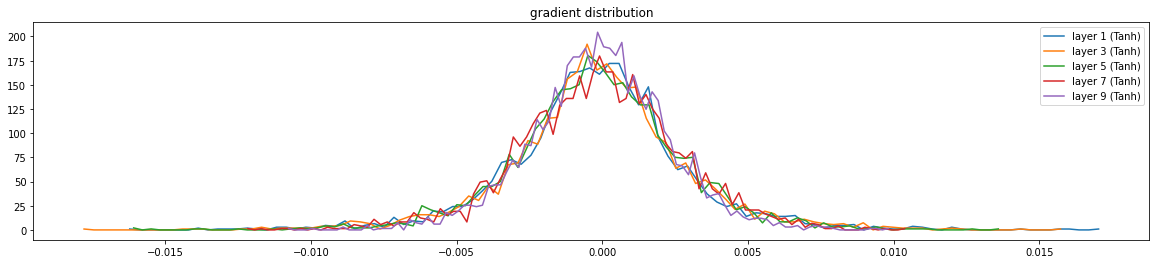

In [131]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000772 | std 9.714620e-03 | grad:data ratio 9.714506e-03
weight  (30, 100) | mean -0.000036 | std 8.734045e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424625e-03 | grad:data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.242012e-03 | grad:data ratio 3.681917e-02
weight (100, 100) | mean +0.000007 | std 6.161664e-03 | grad:data ratio 3.650615e-02
weight (100, 100) | mean +0.000069 | std 5.222000e-03 | grad:data ratio 3.102275e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229573e-01


Text(0.5, 1.0, 'weights gradient distribution')

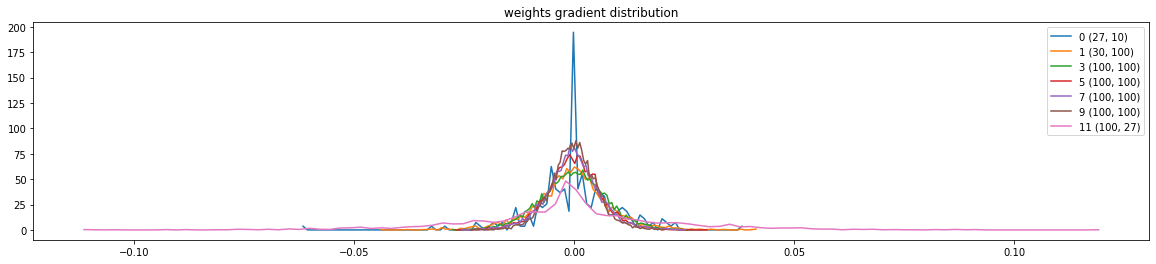

In [132]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

----
The weights gradient distribution is getting better.

----

## 2.5.  Update-to-Data Ratio over Time<a id="205"></a>
-----
Let's visualize one more plot that is essential when training neural networks. The gradient-to-data ratio isn't actually that informative because what matters in the end is not the gradient-to-data ratio, but the update-to-data ratio. This is the amount by which we will actually change the data in these tensors.

### No need for re-running cells in section 1.8

----

In [111]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [112]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

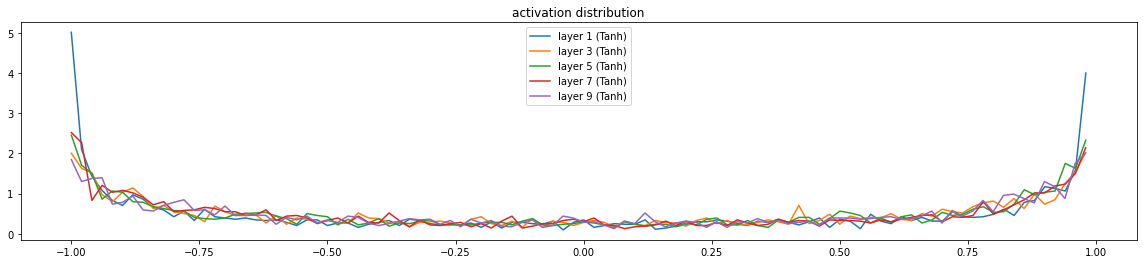

In [113]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

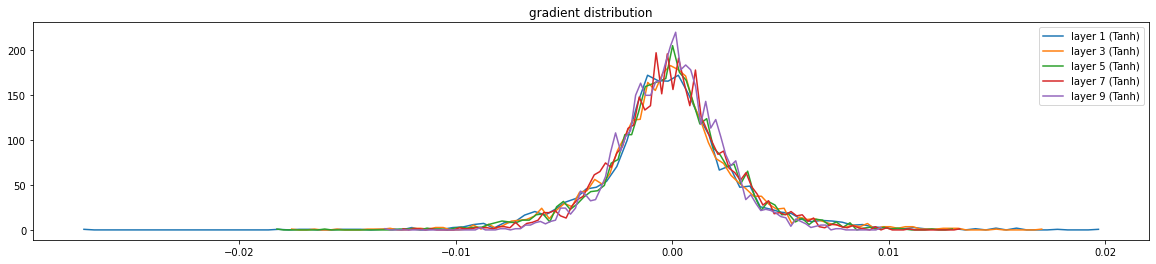

In [114]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214556e-02
weight (100, 100) | mean +0.000033 | std 7.821212e-03 | grad:data ratio 4.653362e-02
weight (100, 100) | mean -0.000107 | std 6.655620e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean +0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


Text(0.5, 1.0, 'weights gradient distribution')

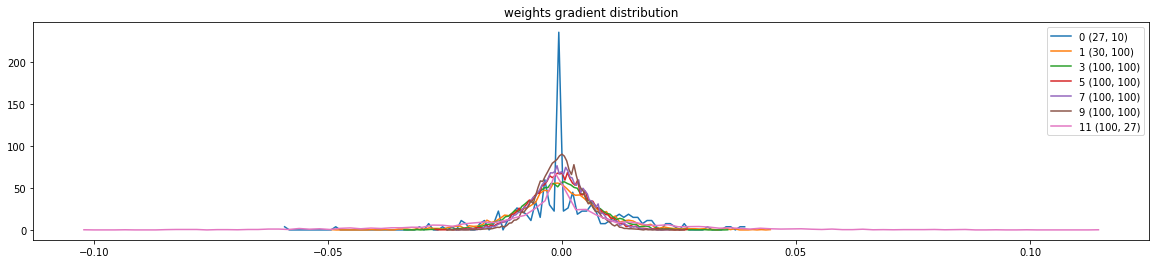

In [115]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

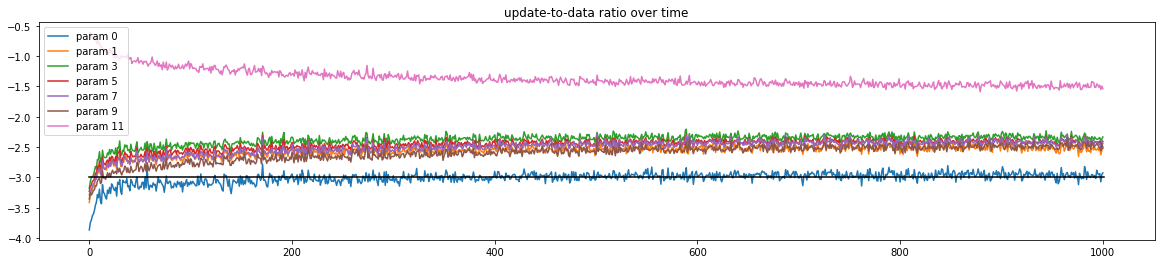

In [116]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
The plot is showing how update-to-data ratios evolve during initialization and then stabilize during training. Alongside these updates, I'm also plotting an approximate guide value, which roughly should be around $10^{-3}$ (1E-3). This means that the values in this tensor take on certain magnitudes, and the updates to them at every iteration are no more than roughly $1/1000$ of those actual magnitudes.

The **final layer's ratio (**pink line**) is an outlier** due to the <u>artificial shrinkage of that layer to keep the softmax output unconfident.</u> We multiplied the weight by $0.1$ during initialization to reduce the last layer's prediction confidence. 
```
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
```
This temporarily resulted in very low values inside the tensor, causing a high ratio. However, as the weight learns and adapts over time, the ratio stabilizes. If anything, the learning rate here is slightly on the higher side, as we're above the black line at around $-2.5$, rather than $-3$. However, everything seems to be stabilizing, so this looks like a decent setting for the learning rate and other parameters. This is something to keep an eye on.

---
Let's also monitor the evolution of the update ratio for all parameters, ensuring it's not too far above $10^{-3}$ (roughly $-3$ on a log plot). If it's below $-3$, it usually means the parameters are training too slowly, indicating a low learning rate. Let's **experiment with a learning rate of $0.001$ ($10^{-3}$).** If the learning rate is too low, this plot will reveal it. 

----

In [117]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [118]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.001 #0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2962


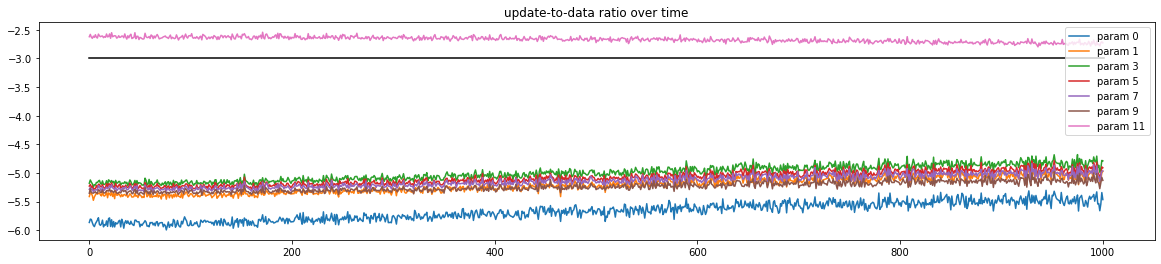

In [119]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
As you can see, all the updates are extremely small, with a magnitude 10,000 times smaller ($10^{-5}$) than the original values in the tensor. This is a symptom of training too slowly. This plot helps you set the learning rate and monitor its effectiveness, which is essential to keep track of.

----
**How do we identify miscalibration in neural networks?** When things are miscalibrated, you'll notice quickly. For example, let's say we forgot to apply fan-in normalization, so the weights inside the linear layers are just random Gaussian samples. What happens then?

### Re-run the 1st cell with code only in [section 1.8](#108) and remove `1/fan_in**0.5` from `Linear` class module.

----

In [134]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.7561


layer 1 (      Tanh): mean -0.09, std 0.99, saturated: 96.66%
layer 3 (      Tanh): mean -0.00, std 0.98, saturated: 91.16%
layer 5 (      Tanh): mean -0.03, std 0.98, saturated: 90.97%
layer 7 (      Tanh): mean -0.02, std 0.97, saturated: 89.66%
layer 9 (      Tanh): mean +0.05, std 0.97, saturated: 89.59%


Text(0.5, 1.0, 'activation distribution')

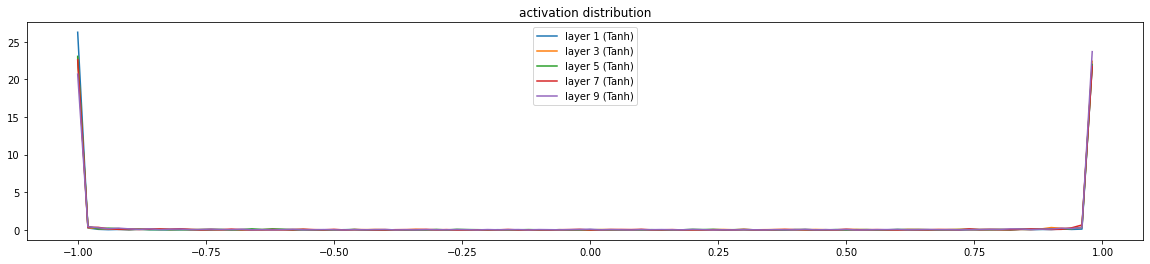

In [135]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.002828, std 1.145645e-01
layer 3 (      Tanh): mean -0.000349, std 4.318817e-02
layer 5 (      Tanh): mean -0.000362, std 1.563181e-02
layer 7 (      Tanh): mean +0.000011, std 5.319492e-03
layer 9 (      Tanh): mean -0.000002, std 1.716267e-03


Text(0.5, 1.0, 'gradient distribution')

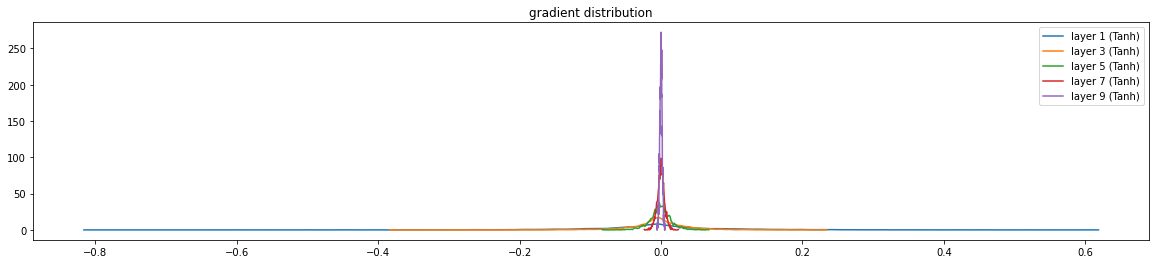

In [136]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000679 | std 3.216631e-01 | grad:data ratio 1.314245e-01
weight  (30, 100) | mean -0.001150 | std 1.615392e-01 | grad:data ratio 8.442890e-02
weight (100, 100) | mean -0.000338 | std 4.041072e-02 | grad:data ratio 2.420024e-02
weight (100, 100) | mean +0.000032 | std 1.410338e-02 | grad:data ratio 8.395711e-03
weight (100, 100) | mean -0.000030 | std 5.024395e-03 | grad:data ratio 3.005201e-03
weight (100, 100) | mean +0.000008 | std 1.732973e-03 | grad:data ratio 1.035605e-03
weight  (100, 27) | mean -0.000000 | std 3.035493e-02 | grad:data ratio 4.860011e-01


Text(0.5, 1.0, 'weights gradient distribution')

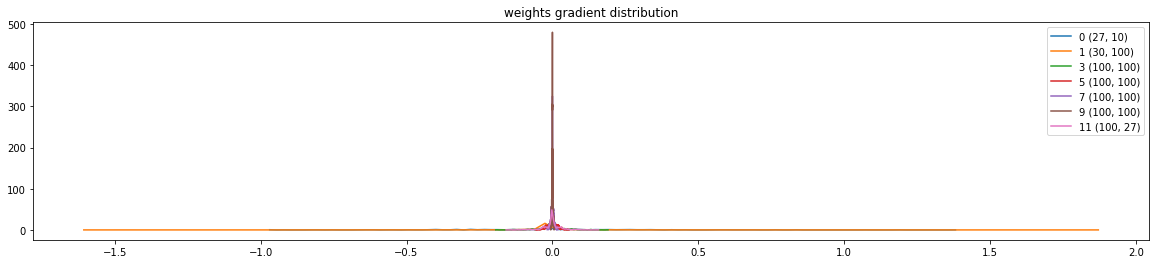

In [137]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

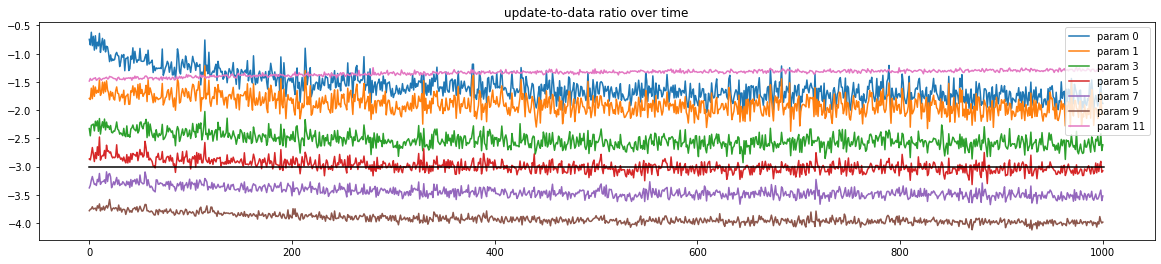

In [138]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
The activation plot portrays that **neurons are too saturated, gradients are messed up, and the weight histograms is asymmetric.** In the update-to-data ratio plot, we see a discrepancy in how fast layers are learning, with some learning too quickly: ratios of $\boldsymbol{-1, -1.5}$ are not ideal, and we should aim for around $\boldsymbol{-3}$. This is how miscalibration manifests, and these plots help bring it to our attention so we can address it.

Basically when things go wrong in the neural network, the activation plot will show saturated neurons, gradient and weight histograms will be messed up, and layers will learn at different rates. These plots help detect miscalibration, allowing you to address the issues.

----

---------
<br><br><a id="3"></a>
# 3. `BatchNorm`: Visualizations
-------------------------------------------------------
Okay, so far we've seen that **when we have this `Linear`-`Tanh` sandwich, we can precisely calibrate the gains to make activations, gradients, parameters, and updates look decent. However, <u>it feels like balancing a pencil on your finger, as the gain requires very precise calibration.</u>** Now, let's introduce batch normalization layers into the mix and see how they help fix the problem.

----

In [140]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


----
Since the last layer is batch normalization, we wouldn't adjust the weight to make the softmax less confident. Instead, we'd adjust the gamma variable (`layers[-1].gamma *= 0.1`), which multiplicatively interacts with the output of the normalization. 
```
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
```
Remember, `gamma` is the variable that scales the output of the batch normalization layer. So, we can initialize this sandwich and train it now.

----

In [141]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

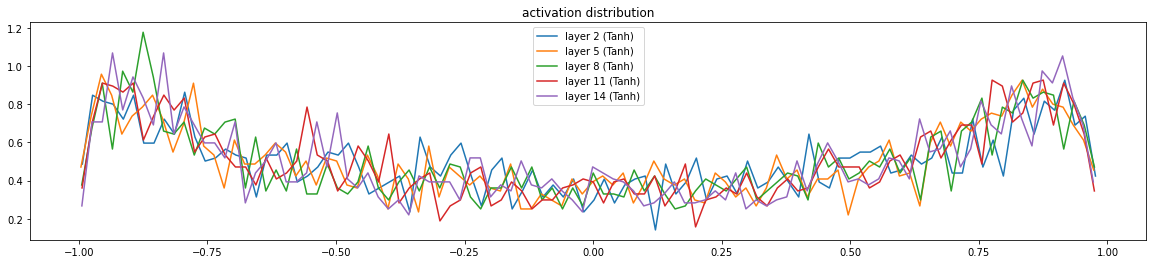

In [142]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.682960e-03
layer 5 (      Tanh): mean -0.000000, std 3.262612e-03
layer 8 (      Tanh): mean +0.000000, std 2.973733e-03
layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584295e-03


Text(0.5, 1.0, 'gradient distribution')

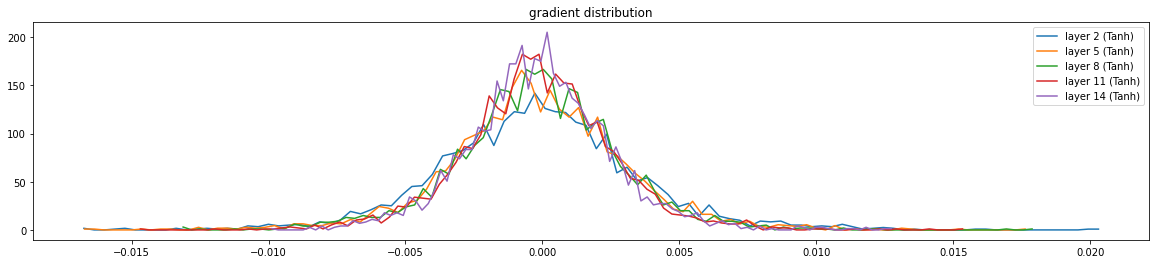

In [143]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019890e-02 | grad:data ratio 1.018850e-02
weight  (30, 100) | mean +0.000092 | std 8.238443e-03 | grad:data ratio 2.635843e-02
weight (100, 100) | mean +0.000031 | std 7.318125e-03 | grad:data ratio 4.377152e-02
weight (100, 100) | mean -0.000019 | std 6.662030e-03 | grad:data ratio 3.949899e-02
weight (100, 100) | mean -0.000019 | std 5.821520e-03 | grad:data ratio 3.468164e-02
weight (100, 100) | mean +0.000053 | std 5.445302e-03 | grad:data ratio 3.243371e-02
weight  (100, 27) | mean -0.000165 | std 1.046846e-02 | grad:data ratio 6.281274e-02


Text(0.5, 1.0, 'weights gradient distribution')

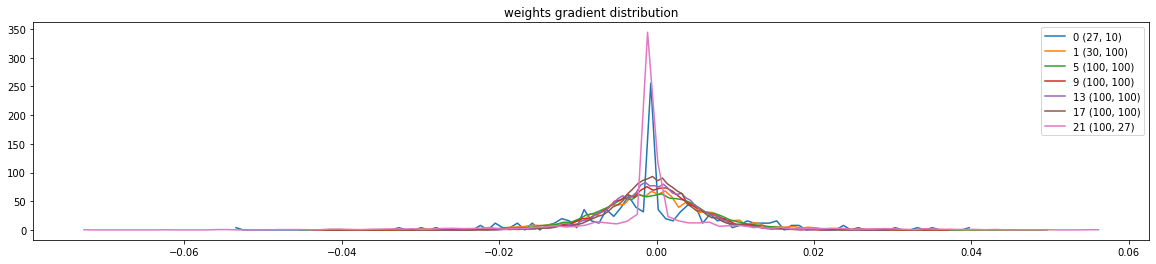

In [144]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

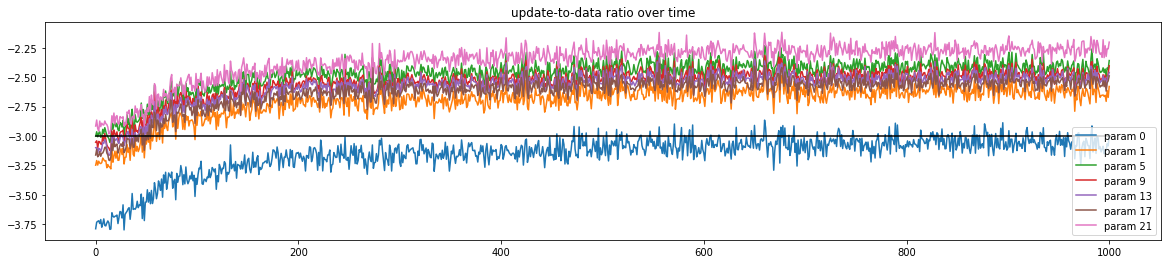

In [145]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
We can see that the activations look very good, and it's no surprise that they do, since there's a normalization layer (`batchNorm`) before every `tanh` layer. The activations have a standard deviation of roughly $\boldsymbol{0.65}$, a very low saturation of approximately $\boldsymbol{2\%}$, and roughly equal standard deviation (range: $\boldsymbol{0.63 - 0.65}$) throughout the entire network, making everything look very homogeneous. The gradients, weights, and their distributions all look good, and the updates look reasonable too. While we're going above $\boldsymbol{-3}$ a little bit, it's not by too much, so all the parameters are training at roughly the same rate.

---
Now, **we've gained robustness against the gain of these linear layers.** For example, I can set the gain to $\boldsymbol{0.2}$, much lower than `tanh` gain. Let's visualize the model's behavior in response to gain changes (`layer.weight *= 0.2`) in the linear layers.
```
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 0.2
```

----

In [152]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5.0 #0.2

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [153]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean +0.00, std 0.66, saturated: 2.00%
layer 8 (      Tanh): mean +0.00, std 0.66, saturated: 1.47%
layer 11 (      Tanh): mean +0.00, std 0.66, saturated: 1.22%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 0.72%


Text(0.5, 1.0, 'activation distribution')

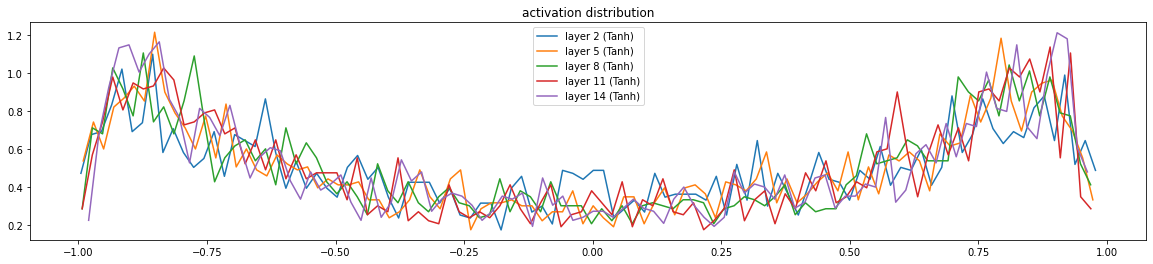

In [148]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 1.249227e-03
layer 5 (      Tanh): mean -0.000000, std 1.097231e-03
layer 8 (      Tanh): mean +0.000000, std 9.477262e-04
layer 11 (      Tanh): mean -0.000000, std 9.355907e-04
layer 14 (      Tanh): mean -0.000000, std 1.049949e-03


Text(0.5, 1.0, 'gradient distribution')

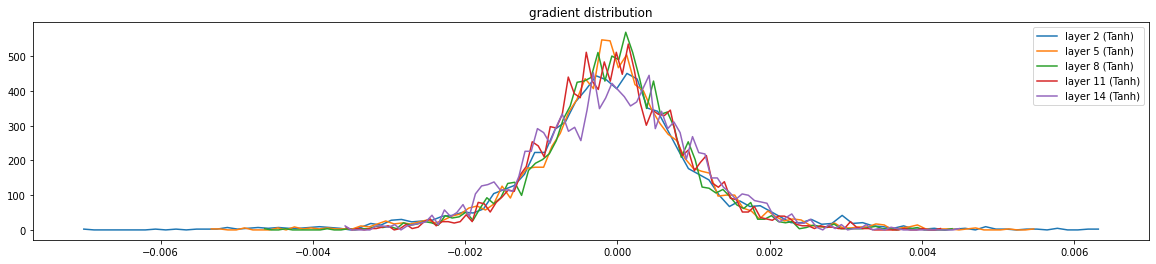

In [149]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.373110e-03 | grad:data ratio 7.366231e-03
weight  (30, 100) | mean +0.000311 | std 1.391912e-02 | grad:data ratio 2.291527e-01
weight (100, 100) | mean +0.000029 | std 6.005433e-03 | grad:data ratio 2.009046e-01
weight (100, 100) | mean -0.000016 | std 5.219657e-03 | grad:data ratio 1.905845e-01
weight (100, 100) | mean -0.000050 | std 5.058551e-03 | grad:data ratio 1.921162e-01
weight (100, 100) | mean -0.000113 | std 5.221355e-03 | grad:data ratio 2.003029e-01
weight  (100, 27) | mean +0.000016 | std 1.234930e-02 | grad:data ratio 2.863980e-01


Text(0.5, 1.0, 'weights gradient distribution')

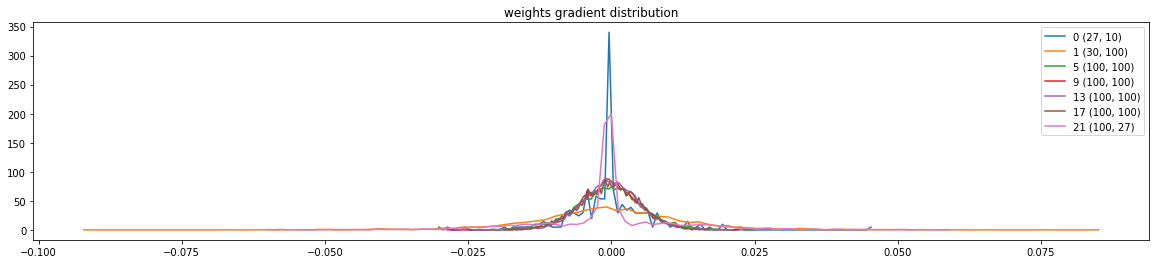

In [150]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

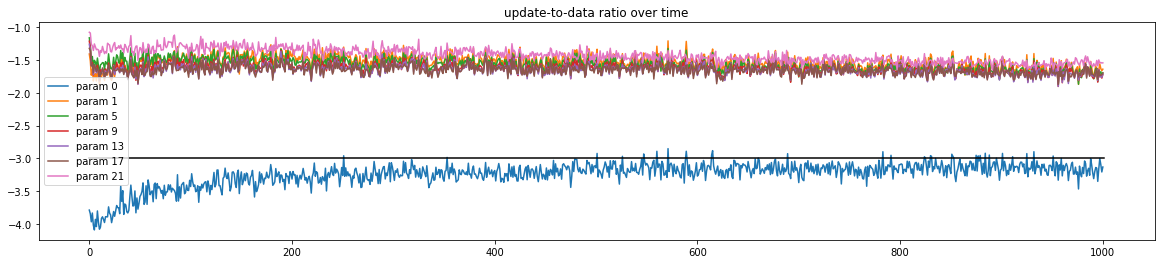

In [151]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
In the plots above, even though we set the `Linear` gain to $\boldsymbol{0.2}$, which is much lower than `tanh` gain, the activations remain unaffected due to explicit normalization. Backward pass gradients and weight gradients look okay, but updates change. Although the forward and backward passes look good, the scale of updates on these parameters is affected. The gradients of the weights are affected too.

Let's try a gain of $\boldsymbol{5.0}$.

----

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.56%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.44%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.31%
layer 14 (      Tanh): mean +0.01, std 0.64, saturated: 2.53%


Text(0.5, 1.0, 'activation distribution')

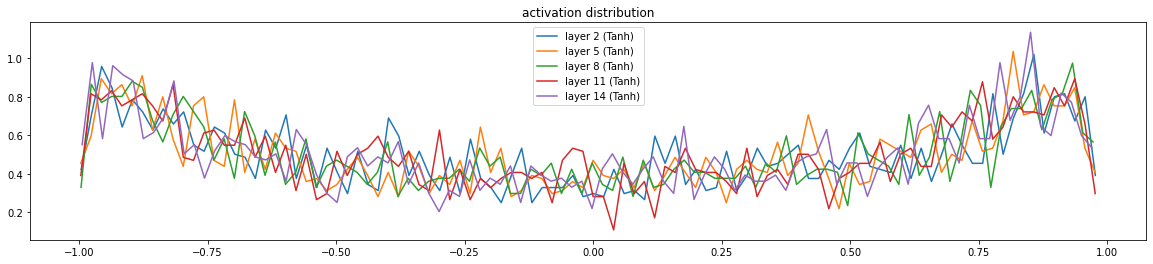

In [154]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.890701e-03
layer 5 (      Tanh): mean -0.000000, std 3.427126e-03
layer 8 (      Tanh): mean +0.000000, std 3.132342e-03
layer 11 (      Tanh): mean -0.000000, std 2.841915e-03
layer 14 (      Tanh): mean -0.000000, std 2.471203e-03


Text(0.5, 1.0, 'gradient distribution')

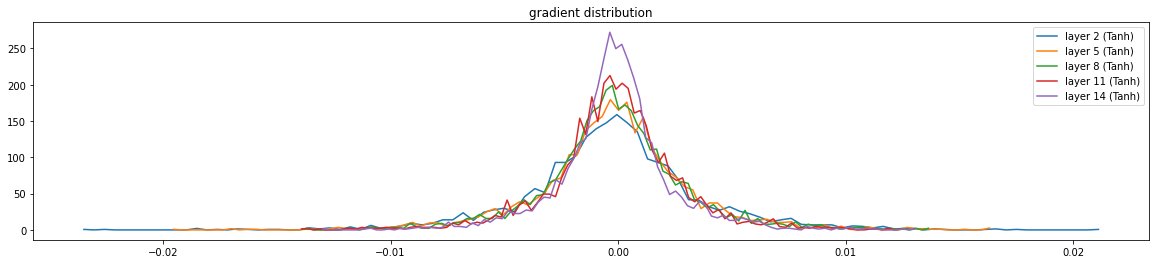

In [155]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 7.996259e-03 | grad:data ratio 7.988947e-03
weight  (30, 100) | mean +0.000040 | std 2.756465e-03 | grad:data ratio 2.946202e-03
weight (100, 100) | mean +0.000025 | std 2.622192e-03 | grad:data ratio 5.261246e-03
weight (100, 100) | mean +0.000005 | std 2.396153e-03 | grad:data ratio 4.757304e-03
weight (100, 100) | mean -0.000004 | std 2.191798e-03 | grad:data ratio 4.369890e-03
weight (100, 100) | mean -0.000007 | std 1.964616e-03 | grad:data ratio 3.913205e-03
weight  (100, 27) | mean -0.000026 | std 3.231944e-03 | grad:data ratio 6.537114e-03


Text(0.5, 1.0, 'weights gradient distribution')

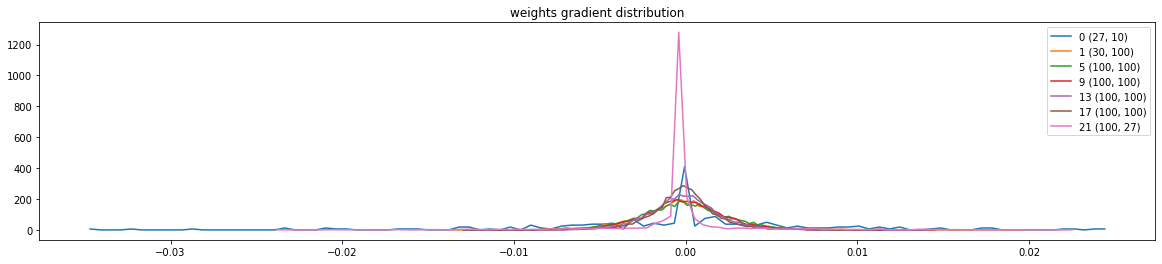

In [156]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

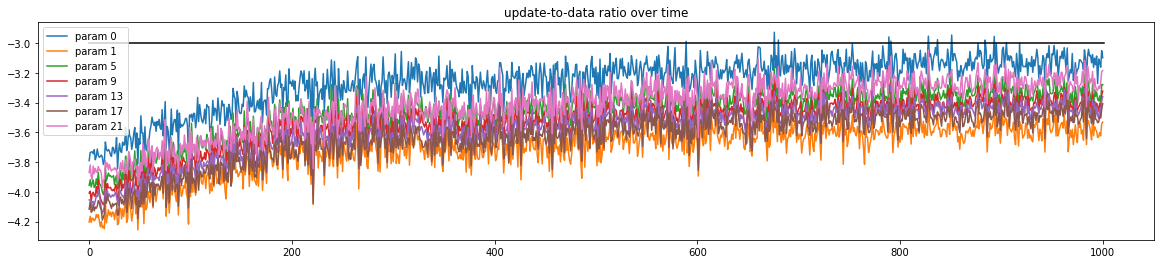

In [157]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
We still don't get a completely free pass to use arbitrary weights, but everything else is more robust in terms of forward pass, backward pass and weight gradients. However, **we still need to retune the learning rate if we change the scale of incoming activations into `batchnorm`.** For instance in this update plot above, <u>increasing the gain results in smaller updates (slower learning: $-4$)</u>. This is because the batch normalization backward pass interacts with the scale of incoming activations, affecting the scale of these weights' updates.

---

Finally, when using batch normalization, we don't necessaarily need gain (set gain to $\boldsymbol{1}$: `layer.weight *= 1`) in the linear layers or fan-in normalization 
- remove `1/fan_in**0.5` in `init` function in `Linear` class in [Section 1.8](#108)<br>
```
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0
```
```
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) 
        self.bias = torch.zeros(fan_out) if bias else None
```

----

In [192]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [184]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 2.50%


Text(0.5, 1.0, 'activation distribution')

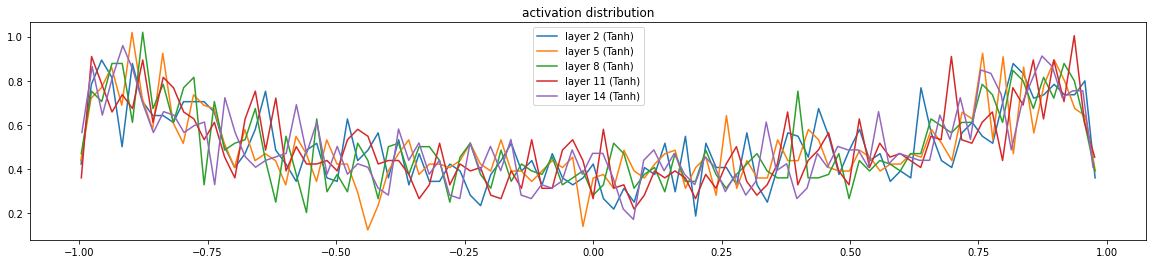

In [169]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.093912e-03
layer 5 (      Tanh): mean +0.000000, std 2.661322e-03
layer 8 (      Tanh): mean +0.000000, std 2.426212e-03
layer 11 (      Tanh): mean -0.000000, std 2.269458e-03
layer 14 (      Tanh): mean -0.000000, std 1.983030e-03


Text(0.5, 1.0, 'gradient distribution')

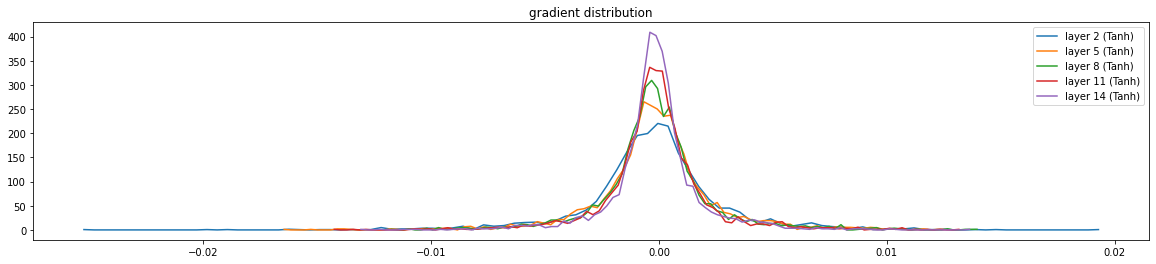

In [170]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 6.705949e-03 | grad:data ratio 6.700180e-03
weight  (30, 100) | mean -0.000003 | std 2.026517e-03 | grad:data ratio 1.977297e-03
weight (100, 100) | mean +0.000013 | std 1.104427e-03 | grad:data ratio 1.108055e-03
weight (100, 100) | mean +0.000005 | std 9.566540e-04 | grad:data ratio 9.497145e-04
weight (100, 100) | mean +0.000003 | std 8.406342e-04 | grad:data ratio 8.380435e-04
weight (100, 100) | mean +0.000001 | std 7.872585e-04 | grad:data ratio 7.840728e-04
weight  (100, 27) | mean -0.000002 | std 1.212762e-03 | grad:data ratio 1.226612e-03


Text(0.5, 1.0, 'weights gradient distribution')

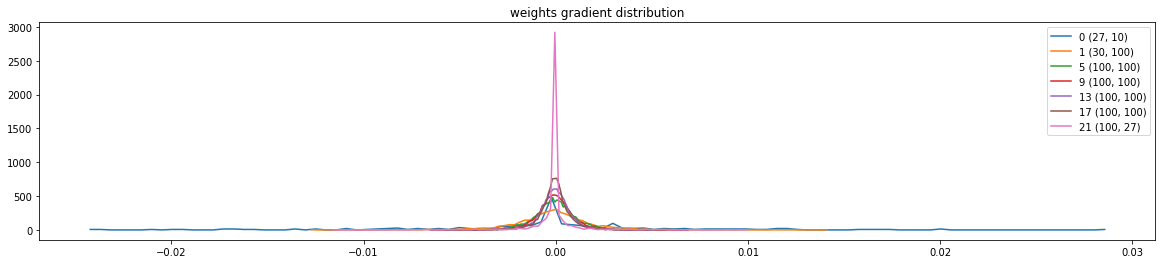

In [171]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

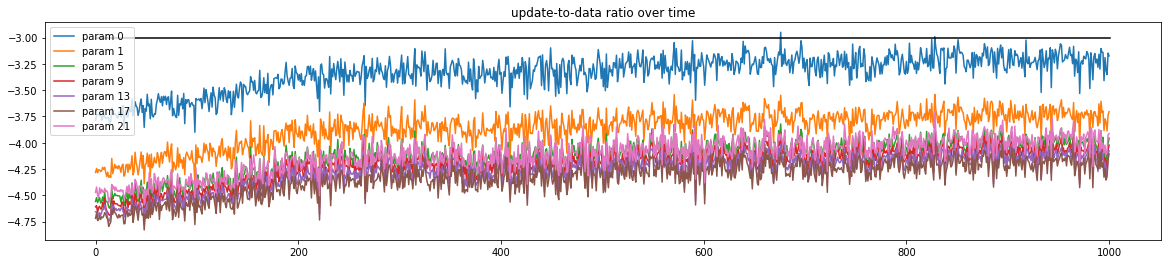

In [172]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
If **we remove `fan-in`,** <u>the weights become _random gaussian_, but batch normalization ensures relatively good behavior.</u> The forward pass, gradients, and weight updates look good even though some layers show long/wide tails. However, we're significantly below $\boldsymbol{-3}$, so we need to increase the batch normalization learning rate to train properly. From the updates plot, it looks like we need to $\boldsymbol{10}\textbf{X}$ the learning rate (`lr = 1.0`) to reach around $\boldsymbol{-3}$ ($\boldsymbol{10^{-3}}$)

----

In [193]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 1.0 #0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 3.91%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.53%
layer 8 (      Tanh): mean -0.02, std 0.63, saturated: 3.09%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 2.69%
layer 14 (      Tanh): mean +0.02, std 0.64, saturated: 3.34%


Text(0.5, 1.0, 'activation distribution')

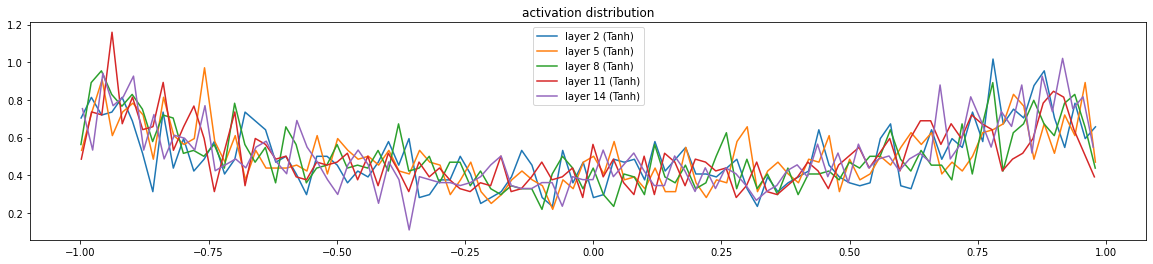

In [194]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.081716e-03
layer 5 (      Tanh): mean +0.000000, std 3.513451e-03
layer 8 (      Tanh): mean +0.000000, std 3.458265e-03
layer 11 (      Tanh): mean -0.000000, std 3.407234e-03
layer 14 (      Tanh): mean +0.000000, std 3.295504e-03


Text(0.5, 1.0, 'gradient distribution')

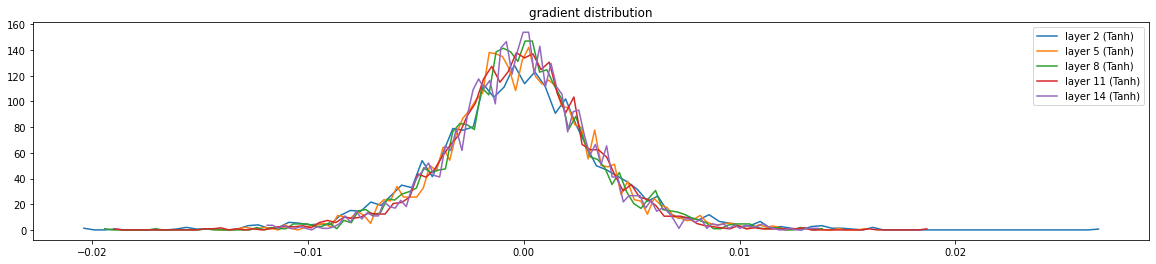

In [195]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.340195e-03 | grad:data ratio 8.083643e-03
weight  (30, 100) | mean +0.000061 | std 2.610465e-03 | grad:data ratio 2.540102e-03
weight (100, 100) | mean -0.000013 | std 1.353517e-03 | grad:data ratio 1.356913e-03
weight (100, 100) | mean -0.000005 | std 1.178780e-03 | grad:data ratio 1.169536e-03
weight (100, 100) | mean -0.000005 | std 1.124870e-03 | grad:data ratio 1.120831e-03
weight (100, 100) | mean +0.000006 | std 1.150513e-03 | grad:data ratio 1.145343e-03
weight  (100, 27) | mean -0.000025 | std 2.196451e-03 | grad:data ratio 2.218108e-03


Text(0.5, 1.0, 'weights gradient distribution')

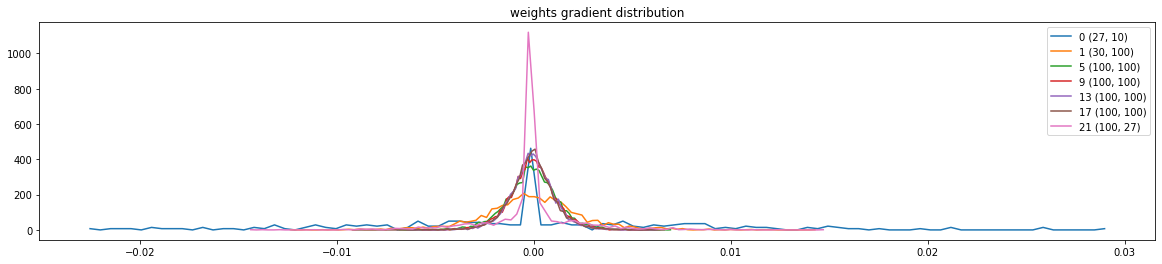

In [196]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

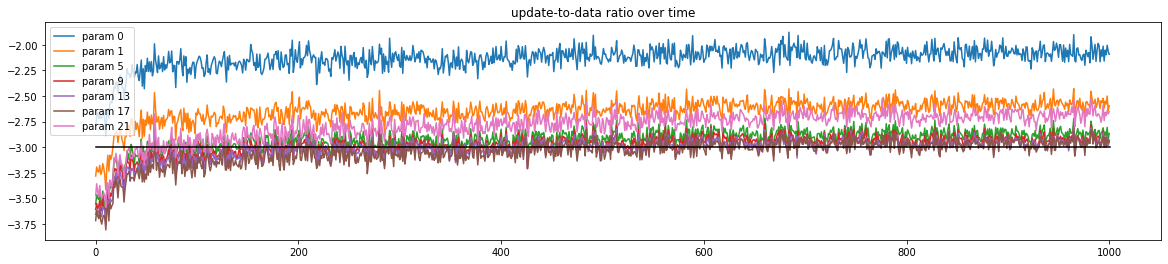

In [197]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

----
By changing the `learning_rate` to $\boldsymbol{1.0}$ and reinitializing, everything looks good, and we expect a successful training run. **In short, we're significantly more robust to the gain of these linear layers, whether or not we apply `fan-in`.** We can change the gain but we need to consider the scale of update-to-data ratios and ensure proper learning rate calibration. As a result, the activations, forward and backward passes, and update ratios are all looking much more well-behaved, with the exception of the global scale, which may need adjustment.

----

---------
<br><br><a id="4"></a>
# 4. `BatchNorm`: Overall Summary
-------------------------------------------------------

In summary, I aimed to achieve three things in section 3:
1. **Introduce batch normalization,** a modern innovation that stabilizes deep neural networks and their training. I hope it's clear how batch normalization works and how it's used in neural networks: 
$$ \text{BN}_{\gamma, \beta}(x_i) = \gamma  * \frac{x_i - \mu_\beta}{\sqrt{\sigma_{beta}^2 + \epsilon}} + \beta $$<br><br>
2. **Modularize our code** by wrapping it into layers like `Linear`, `BatchNorm1D`, `Tanh`, etc. These layers can be stacked like Lego blocks to build neural networks. I've designed the API to be identical to `PyTorch`'s, so you can use `PyTorch`'s implementation by prepending "`torch.nn.`" to the layer names.<br><br>
```
layers = [
  nn.Linear(n_embd * block_size, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
  ...]
```
3. **Introduce Diagnostic Tools** to understand whether your neural network is in a good state dynamically. We examined statistics, histograms, and distributions for the forward pass activations and backward pass gradients. Also, we examined the weight updates during stochastic gradient descent: $w \leftarrow w - \alpha \frac{\partial L}{\partial w}$, their means, standard deviations, and ratios of gradients to data (or updates to data). Typically, people monitor these metrics over time, not just at a single iteration. <u>A good rough heuristic is to aim for a log-scale ratio of around $-3$</u>; if it's too high, the learning rate or updates might be too big, and if it's too small, the learning rate might be too small: $\log \frac{\partial L}{\partial w} \approx -3$.<br><br>

For improving neural network model performance, some of the parameters listed and talked about above are tunable: 
* learning rate
* linear layer gain
* fan-in normalization on/off, etc. 

----

In [198]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [199]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

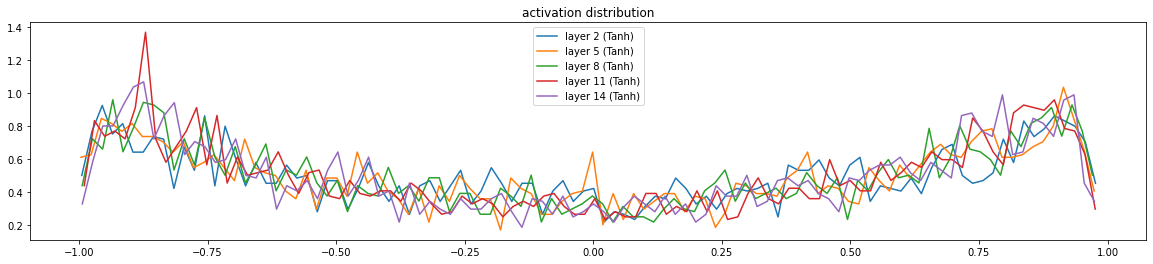

In [200]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045742e-03
layer 11 (      Tanh): mean -0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

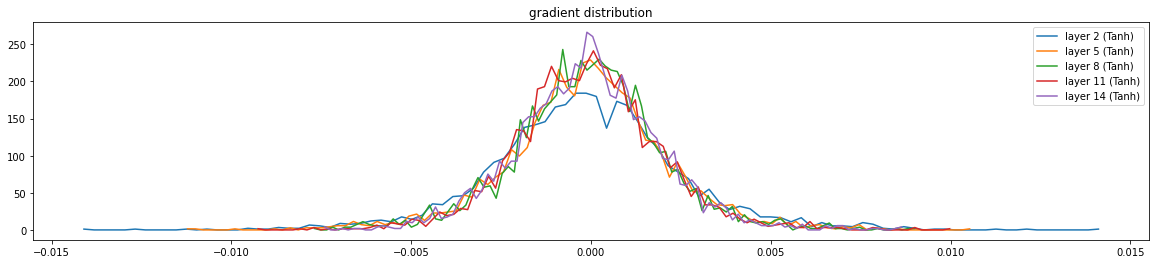

In [201]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012626e-03
weight  (30, 100) | mean +0.000246 | std 9.241071e-03 | grad:data ratio 4.881088e-02
weight (100, 100) | mean +0.000113 | std 7.132875e-03 | grad:data ratio 6.964615e-02
weight (100, 100) | mean -0.000086 | std 6.234302e-03 | grad:data ratio 6.073738e-02
weight (100, 100) | mean +0.000052 | std 5.742183e-03 | grad:data ratio 5.631479e-02
weight (100, 100) | mean +0.000032 | std 5.672202e-03 | grad:data ratio 5.570123e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


Text(0.5, 1.0, 'weights gradient distribution')

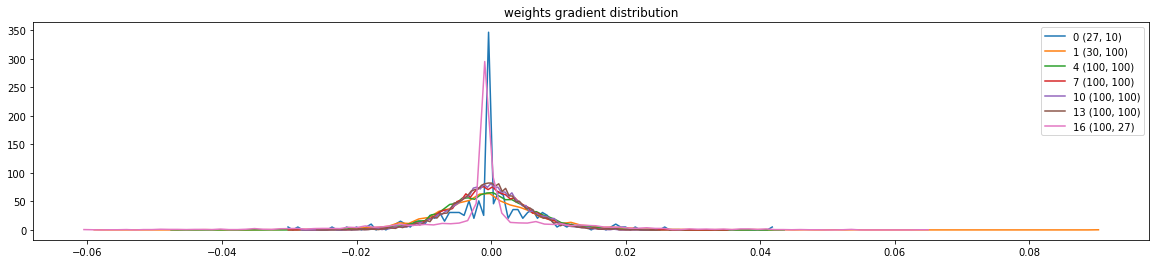

In [202]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

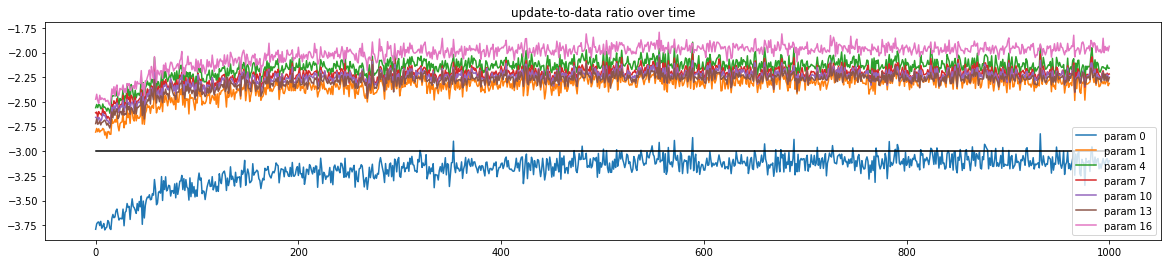

In [203]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('update-to-data ratio over time');

In [204]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188


In [206]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiunellaia.
chriiv.
kalein.
dhlm.
join.
qhinn.
sroin.
arian.
quiqaelogiearyxix.
kaeklinsan.
ed.
ecoia.
gtleley.


----
As per Karpathy, there are several things I didn't aim to achieve in this lecture. 
* I **didn't try to beat our previous performance by introducing a batch normalization layer**. However, I did <u>try using the learning rate diagnostic procedure I described earlier to train a batch normalization layer,</u> and I ended up with results similar to what we achieved before. This is <u>because our performance is no longer bottlenecked by optimization, but rather by **the context length chosen.**</u> Currently, we're taking only $\boldsymbol{3}$ characters to predict the $\boldsymbol{4\textbf{th}}$, and I believe we need to go beyond that. I also need to explore more powerful architectures like recurrent neural networks and transformers to further improve the log probabilities on this dataset.
* I also **didn't provide a full explanation of all the activations, gradients, backward pass, and statistics of all the gradients**. You may have <u>found some parts unintuitive or confusing, such as **how changing the gain requires a different learning rate.**</u> I didn't delve into the full details, as it would require <u>examining the backward pass of each layer and gaining an intuitive understanding of how it works</u>. The purpose of this lecture was simply to introduce you to diagnostic tools and their appearance. There is still much work to be done on the intuitive level to understand initialization, backward pass, and how they interact.

----

Don't feel too bad, as we're getting to the cutting edge of where the field is. We certainly haven't solved initialization, backpropagation, or update rules, and these are still active areas of research. People are still trying to figure out the best ways to initialize the networks, the best update rules to use, and so on. While we don't have all the answers, at least we're making progress, and we have tools to tell us whether we're on the right track. I hope you enjoyed this lecture, and I'll see you next time!

----

---------
<br><br><a id="5"></a>
# 5. Conclusion
---
Here is a summary of this notebook in 5 points:
1. This notebook discusses the importance of understanding forward pass activations and backward pass gradients in training neural networks, especially in larger and more complex networks like RNNs and pitfalls ecountered when they are improperly scaled. It demonstrates how to implement an MLP and optimize it, and introduces batch normalization, a technique that standardizes hidden states to make them roughly Gaussian.<br><br>
2. This notebook covers the implementation of batch normalization in `PyTorch`, including estimating the mean and standard deviation during training, and discusses residual networks (`ResNets`), which are deep neural networks used for image classification tasks.<br><br>
3. This notebook also discusses the initialization of weights using a uniform distribution, the concept of batch normalization layer in `PyTorch`, and the challenges of scaling weight matrices and biases during neural network initialization.<br><br>
4. Additionally, this notebook introduces diagnostic tools for understanding whether our neural network is in a good state dynamically by examining forward pass activations, backward pass gradients, weights gradients, and update-to-data ratios to keep track of how great the updates are to the values in the tensors. It discusses what happens when fan-in normalization is not properly applied in the weights, how batch normalization can address miscalibration problems and the impact of learning rate on update parameters.<br><br>
5. Finally, this notebook provides an overview of the three things the speaker hoped to achieve (introducing diagnostic tools, modularizing the code, and introducing batch normalization), and discusses the remaining work to be done in understanding initialization and the backward pass in neural networks, with optimism about the future of the field.<br><br>


-----
<br><br>
# Appendix
----

------
## C1. Kaiming Normal Distribution in `PyTorch`<a id="c1"></a>
-----

![kaiming_normal_distribution](_imgs/kaiming_he.png)
([Source](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_))

----
 The [gain function](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain) will vary depending on the type of non-linearity being used. 
![calculate_gain](_imgs/gain.png)
([Source](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain))

----

------
## C2. `BatchNorm` Forward Pass as a Widget<a id="c2"></a>
-----

In [207]:
# DONE; BONUS content below, not covered in video

In [4]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

------
## C3. `Linear`: Activation Statistics of Forward & Backward Pass<a id="c3"></a>
-----

In [5]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


------
## C4. `Linear` + `BatchNorm`: Activation Statistics of Forward & Backward Pass<a id="c4"></a>
-----

In [6]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559


-----
<br><br><a id="e1"></a>
# Exercises
----

1. I did not get around to seeing what happens when you initialize all weights and biases to $0$. Try this and train the neural net. You might think either that 
* the network trains just fine or 
* the network doesn't train at all, but actually it is 
* the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
2. `BatchNorm`, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm $\gamma$ and $\beta$ can be "folded into" the weights of the preceding linear layers, effectively erasing the need to forward it at test time. 
    - Set up a small 3-layer MLP with batchnorms, 
    - train the network, 
    - then "fold" the batchnorm gamma/beta into the preceeding linear layer's `W`, `b` by creating a new `W2`, `b2` and erasing the batch norm. 
    - Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

-----
<br><br><a id="r1"></a>
# References
----
1. "<u>Building makemore Part 3: Activations & Gradients, BatchNorm</u>" [youtube video](https://www.youtube.com/watch?v=P6sfmUTpUmc), Oct 2022.
2. Andrej Karpathy **Makemore** [github repo](https://github.com/karpathy/makemore).
3. Andrej Karpathy  **Neural Networks: Zero to Hero** [github repo](https://github.com/karpathy/nn-zero-to-hero/tree/master) ([notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb) to follow video tutorial with).
4. Article: "<u>Multilayer Perceptron with Andrej Karpathy</u>" - Kavishka Abeywardana, Pt [3](https://medium.com/@kdwa2404/multilayer-perceptron-with-andrej-karpathy-part-3-fa75319c7403), [4](https://medium.com/@kdwa2404/multilayer-perceptron-with-andrej-karpathy-part-4-c63f08643f26), [5](https://medium.com/@kdwa2404/multilayer-perceptron-with-andrej-karpathy-part-5-a72db9905427), March 2024.
5. Article: "<u>Implementing a Character-Level Language Model (Activations, Gradients, BatchNorm)</u>" - Tahir Rauf, Pt [3A](https://medium.com/@tahir.rauf/implementing-a-character-level-language-model-activations-gradients-batchnorm-part-3a-eb4e50cfcbbd), Dec 2023.
6. "<u>Deep Dive into AI: Implementing Batch Normalization and Kaiming init through MLP</u>" - Ada Choudhry, [article](https://medium.com/@adachoudhry26/deep-dive-into-ai-implementing-batch-normalization-and-kaiming-init-through-mlp-4800442e0611), Mar 2024.
7. "<u>Notes on Andrej Karpathy’s makemore videos. Part 3.</u>" - Maxime Markov, [article](https://medium.com/@maxmarkovvision/notes-on-andrej-karpathys-makemore-videos-part-3-d4b25d56540c), Jan 2023.
8. Twitter: "<u>Why remove BatchNorm?</u>" - Soham De, [tweet](https://twitter.com/sohamde_/status/1360219421713838080?lang=en), Feb 2021.
9. "<u>Resnet Architecture Explained</u>" - Siddhesh Bangar, [article](https://medium.com/@siddheshb008/resnet-architecture-explained-47309ea9283d), Jul 2022.
10. "<u>Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</u>" - Kaiming He et. al., [Academic Paper](https://arxiv.org/pdf/1502.01852), Microsoft, Feb 2015.
11. "<u>Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift</u>" - Sergey Ioffe, Christian Szegedy, [Academic Paper](https://arxiv.org/pdf/1502.03167), Google, Mar 2015.
12. "<u>Deep Residual Learning for Image Recognition</u>" - Kaiming He et. al., [Academic Paper](https://arxiv.org/pdf/1512.03385v1), Microsoft, Dec 2015.
13. "<u>Rethinking “Batch” in BatchNorm</u>" - Yuxin Wu, Justin Johnson, [Academic Paper](https://arxiv.org/pdf/2105.07576), Facebook, May 2021.
14. "<u>A Neural Probabilistic Language Model</u>" - Bengio et. al., [Academic Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), Journal of Machine Learning Research, Vol 3. 1137–1155. Mar 2003.
15. PyTorch Resources: [Kaiming Normal Distribution](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_), [Gain Function](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain), [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh), [`ResNet.py`](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
------